In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '5'
import scanpy as sc
import anndata as ad
import h5py  
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy import stats
from utils import MMD, LISI, random_forest, norm_total
from scipy.sparse import csr_matrix
import pandas as pd
from pathlib import Path
from torch.distributions import Normal
from scvi.distributions import NegativeBinomial
from torch.distributions import Poisson, Bernoulli
import muon as mu
import yaml
import shutup
shutup.please()

import sys
sys.path.append('../../Autoencoder')
from autoencoder.data.scrnaseq_loader import RNAseqLoader
from autoencoder.models.base.encoder_model import EncoderModel

# translate h5ad to 10x h5

In [51]:
adata = sc.read_h5ad('/stor/lep/diffusion/multiome/GSE194122_my_models_neurips2021_multiome_BMMC_processed_filtered.h5ad')

num_genes = adata.shape[1]
num_cells = adata.shape[0]
data = adata.X.toarray()
matrix = csr_matrix(data)
adata.var['feature_types'] = adata.var['feature_types'].replace('GEX', 'Gene Expression')
adata.var['feature_types'] = adata.var['feature_types'].replace('ATAC', 'Peaks')
adata.var_names = list(adata.var_names[:(adata.var['feature_types']=='Gene Expression').sum()])+[name.replace('-', ':', 1) for name in adata[:,adata.var['feature_types']=='Peaks'].var_names]
# 创建特征（基因）和条形码（细胞）
features = pd.DataFrame({
    'gene_ids': [f'gene_{i}' for i in range(num_genes)],
    'gene_names': adata.var_names.values
})

barcodes = adata.obs_names.values  # 细胞条形码

# 创建 obs 数据（细胞元数据）
obs = pd.DataFrame({
    'cell_type': adata.obs['cell_type'].values,
}, index=barcodes)

# 创建 var 数据（基因元数据）
var = pd.DataFrame({
    'gene_names': features['gene_names'],
    'feature_type': adata.var['feature_types'].values,
    'genome': ['GRCh38'] * num_genes
}, index=features['gene_ids'])

# 创建 .h5 文件
with h5py.File('/stor/lep/diffusion/multiome/GSE194122_openproblems_neurips2021_multiome_BMMC_processed_filtered.h5', 'w') as f:
    # 保存稀疏矩阵数据
    f.create_dataset('matrix/data', data=matrix.data)
    f.create_dataset('matrix/indices', data=matrix.indices)
    f.create_dataset('matrix/indptr', data=matrix.indptr)
    f.create_dataset('matrix/shape', data=[num_genes,num_cells])  # 确保只保留一个形状数据集

    # 保存特征和基因信息
    f.create_dataset('matrix/name', data=np.array(features['gene_names'].tolist()).astype('S'))
    f.create_dataset('matrix/id', data=np.array(features['gene_ids'].tolist()).astype('S'))

    # 保存细胞条形码
    f.create_dataset('matrix/barcodes', data=np.array(barcodes).astype('S'))

    # 保存 obs 数据
    for column in obs.columns:
        f.create_dataset(f'matrix/{column}', data=obs[column].astype('S'))

    # 保存 var 数据
    for column in var.columns:
        f.create_dataset(f'matrix/{column}', data=var[column].astype('S'))

In [52]:
gen_h5 = sc.read_10x_h5('/stor/lep/diffusion/multiome/GSE194122_openproblems_neurips2021_multiome_BMMC_processed_filtered.h5',gex_only=False)

In [13]:
ttestt = sc.read_10x_h5('/stor/lep/data/BABEL/DM_rep4.h5')
ttestt

AnnData object with n_obs × n_vars = 5517 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

build data for translation training

In [98]:
rna_train = sc.read_h5ad('/stor/lep/workspace/multi_diffusion/babel-main/output/openproblem/train_rna.h5ad')
rna_val = sc.read_h5ad('/stor/lep/workspace/multi_diffusion/babel-main/output/openproblem/valid_rna.h5ad')
rna_test = sc.read_h5ad('/stor/lep/workspace/multi_diffusion/babel-main/output/my_model/truth_rna.h5ad')

atac_train = sc.read_h5ad('/stor/lep/workspace/multi_diffusion/babel-main/output/openproblem/train_atac.h5ad')
atac_val = sc.read_h5ad('/stor/lep/workspace/multi_diffusion/babel-main/output/openproblem/valid_atac.h5ad')
atac_test = sc.read_h5ad('/stor/lep/workspace/multi_diffusion/babel-main/output/openproblem/truth_atac.h5ad')

# rna_train = sc.read_h5ad('/stor/lep/workspace/multi_diffusion/babel-main/output/my_model/train_rna.h5ad')
# rna_val = sc.read_h5ad('/stor/lep/workspace/multi_diffusion/babel-main/output/my_model/valid_rna.h5ad')
# rna_test = sc.read_h5ad('/stor/lep/workspace/multi_diffusion/babel-main/output/my_model/truth_rna.h5ad')

# adata = ad.concat([rna_train,rna_val,rna_test],label='cell_name',keys=['train','val','test'])
# rna_full = sc.read_h5ad('/stor/lep/workspace/multi_diffusion/babel-main/output/openproblem/full_rna_log.h5ad')

# sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata.raw = adata
adata = adata[:, adata.var.highly_variable]

sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

sc.pl.umap(adata, color='cell_name', size=8, title='umap of unconditional generation RNA', show=False)

/home/lep/miniconda3/envs/mm-diffusion/lib/python3.8/site-packages/anndata/_io/h5ad.py:238: OldFormatWarning: Element '/X' was written without encoding metadata.
  d[k] = read_elem(f[k])
/home/lep/miniconda3/envs/mm-diffusion/lib/python3.8/site-packages/anndata/_io/h5ad.py:238: OldFormatWarning: Element '/layers' was written without encoding metadata.
  d[k] = read_elem(f[k])
/home/lep/miniconda3/envs/mm-diffusion/lib/python3.8/site-packages/anndata/_io/specs/methods.py:92: OldFormatWarning: Element '/layers/row_counts' was written without encoding metadata.
  return {k: read_elem(v) for k, v in elem.items()}
/home/lep/miniconda3/envs/mm-diffusion/lib/python3.8/site-packages/anndata/_io/h5ad.py:279: OldFormatWarning: '/obs' was written with a very old version of AnnData. Consider rewriting it.
  warn(
/home/lep/miniconda3/envs/mm-diffusion/lib/python3.8/site-packages/anndata/_io/h5ad.py:238: OldFormatWarning: Element '/obsm' was written without encoding metadata.
  d[k] = read_elem(f[k

<AxesSubplot:title={'center':'umap of unconditional generation RNA'}, xlabel='UMAP1', ylabel='UMAP2'>

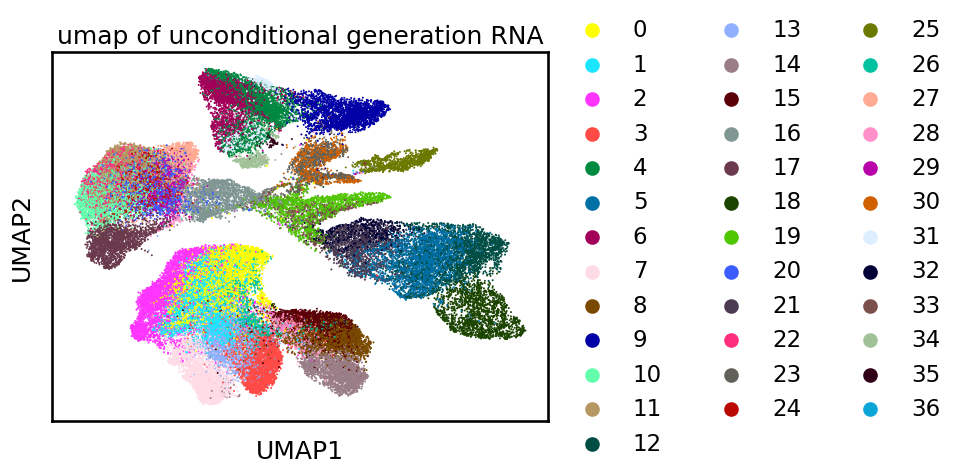

In [100]:
sc.pl.umap(adata, color='leiden', size=8, title='umap of unconditional generation RNA', show=False)

In [155]:
rna_train = sc.read_h5ad('/stor/lep/workspace/multi_diffusion/babel-main/output/openproblem/train_rna.h5ad') #openproblem
rna_val = sc.read_h5ad('/stor/lep/workspace/multi_diffusion/babel-main/output/openproblem/valid_rna.h5ad')
rna_test = sc.read_h5ad('/stor/lep/workspace/multi_diffusion/babel-main/output/openproblem/truth_rna.h5ad')
rna_full = sc.read_h5ad('/stor/lep/workspace/multi_diffusion/babel-main/output/openproblem/full_rna_log.h5ad')
rna_train.X = rna_train.layers['row_counts']
rna_val.X = rna_val.layers['row_counts']
rna_test.X = rna_test.layers['row_counts']
rna_train.obs['leiden'] = rna_full[rna_train.obs_names].obs['leiden']
rna_val.obs['leiden'] = rna_full[rna_val.obs_names].obs['leiden']
rna_test.obs['leiden'] = rna_full[rna_test.obs_names].obs['leiden']

atac_train = sc.read_h5ad('/stor/lep/workspace/multi_diffusion/babel-main/output/openproblem/train_atac.h5ad')
atac_val = sc.read_h5ad('/stor/lep/workspace/multi_diffusion/babel-main/output/openproblem/valid_atac.h5ad')
atac_test = sc.read_h5ad('/stor/lep/workspace/multi_diffusion/babel-main/output/openproblem/truth_atac.h5ad')

mdata = mu.MuData({'rna':rna_train,'atac':atac_train})
mdata.write_h5mu('/stor/lep/data/BABEL/open/train.h5mu')

mdata = mu.MuData({'rna':rna_val,'atac':atac_val})
mdata.write_h5mu('/stor/lep/data/BABEL/open/valid.h5mu')

mdata = mu.MuData({'rna':rna_test,'atac':atac_test})
mdata.write_h5mu('/stor/lep/data/BABEL/open/test.h5mu')

mdata = mu.MuData({'rna':ad.concat([rna_train,rna_val,rna_test],label='batch',keys=['train','val','test']),'atac':ad.concat([atac_train,atac_val,atac_test],label='batch',keys=['train','val','test'])})
mdata.write_h5mu('/stor/lep/data/BABEL/open/all.h5mu')

/home/lep/miniconda3/envs/mm-diffusion/lib/python3.8/site-packages/anndata/_io/h5ad.py:238: OldFormatWarning: Element '/X' was written without encoding metadata.
  d[k] = read_elem(f[k])
/home/lep/miniconda3/envs/mm-diffusion/lib/python3.8/site-packages/anndata/_io/h5ad.py:238: OldFormatWarning: Element '/layers' was written without encoding metadata.
  d[k] = read_elem(f[k])
/home/lep/miniconda3/envs/mm-diffusion/lib/python3.8/site-packages/anndata/_io/specs/methods.py:92: OldFormatWarning: Element '/layers/row_counts' was written without encoding metadata.
  return {k: read_elem(v) for k, v in elem.items()}
/home/lep/miniconda3/envs/mm-diffusion/lib/python3.8/site-packages/anndata/_io/h5ad.py:279: OldFormatWarning: '/obs' was written with a very old version of AnnData. Consider rewriting it.
  warn(
/home/lep/miniconda3/envs/mm-diffusion/lib/python3.8/site-packages/anndata/_io/h5ad.py:238: OldFormatWarning: Element '/obsm' was written without encoding metadata.
  d[k] = read_elem(f[k

In [153]:
test12878_rna = sc.read_h5ad('/stor/lep/workspace/multi_diffusion/babel-main/output/cv_logsplit_01_model_only/truth_rna.h5ad')
test12878_atac = sc.read_h5ad('/stor/lep/workspace/multi_diffusion/babel-main/output/cv_logsplit_01_model_only/truth_atac.h5ad')
test12878_rna.X = test12878_rna.layers['row_counts']
test12878_rna.obs['leiden'] = '36'
mdata = mu.MuData({'rna':ad.concat([rna_train,rna_val,rna_test,test12878_rna],label='batch',keys=['train','val','test','12878']),'atac':ad.concat([atac_train,atac_val,atac_test,test12878_atac],label='batch',keys=['train','val','test','12878'])})
mdata.write_h5mu('/stor/lep/data/BABEL/all_w12878.h5mu')

/home/lep/miniconda3/envs/mm-diffusion/lib/python3.8/site-packages/anndata/_io/h5ad.py:238: OldFormatWarning: Element '/X' was written without encoding metadata.
  d[k] = read_elem(f[k])
/home/lep/miniconda3/envs/mm-diffusion/lib/python3.8/site-packages/anndata/_io/h5ad.py:238: OldFormatWarning: Element '/layers' was written without encoding metadata.
  d[k] = read_elem(f[k])
/home/lep/miniconda3/envs/mm-diffusion/lib/python3.8/site-packages/anndata/_io/specs/methods.py:92: OldFormatWarning: Element '/layers/row_counts' was written without encoding metadata.
  return {k: read_elem(v) for k, v in elem.items()}
/home/lep/miniconda3/envs/mm-diffusion/lib/python3.8/site-packages/anndata/_io/h5ad.py:279: OldFormatWarning: '/obs' was written with a very old version of AnnData. Consider rewriting it.
  warn(
/home/lep/miniconda3/envs/mm-diffusion/lib/python3.8/site-packages/anndata/_io/h5ad.py:238: OldFormatWarning: Element '/obsm' was written without encoding metadata.
  d[k] = read_elem(f[k

In [181]:
mdata = mu.read_h5mu('/stor/lep/data/BABEL/open/test.h5mu')
adata = sc.read_h5ad('/stor/lep/diffusion/multiome/GSE194122_openproblems_neurips2021_multiome_BMMC_processed_filtered.h5ad')
np.unique(adata[mdata['rna'].obs_names].obs['cell_type'].values,return_counts=True)

(array(['B1 B', 'CD14+ Mono', 'CD4+ T activated', 'CD4+ T naive', 'CD8+ T',
        'CD8+ T naive', 'HSC', 'ILC', 'Lymph prog', 'NK', 'Naive CD20+ B',
        'Plasma cell', 'Proerythroblast', 'Transitional B', 'pDC'],
       dtype=object),
 array([   6,    2, 1351,  803, 2298,  216,    3,    1,    2,   28,    6,
           3,    4,    4,    2]))

# diffusion translated

In [566]:
encoder_config = "encoder_multimodal_large"
dataset_path = "/stor/lep/data/BABEL/all_w12878.h5mu"  #"/stor/lep/diffusion/multiome/openproblems_2500gene_03atac_full.h5mu" #
covariate_keys = "leiden"
num_class = 36 #37
ae_path = "/stor/lep/workspace/multi_diffusion/CFGen/project_folder/experiments/train_autoencoder_babel_multimodal_layernorm_wd1e4/checkpoints/last.ckpt"

In [254]:
encoder_config = "encoder_multimodal_small"
dataset_path = "/stor/lep/diffusion/multiome/openproblem_filtered4perturb.h5mu"  #"/stor/lep/diffusion/multiome/openproblems_2500gene_03atac_full.h5mu" #
covariate_keys = "cell_type"
num_class = 22 #37
ae_path = "/stor/lep/workspace/multi_diffusion/CFGen/project_folder/experiments/train_autoencoder_openproblem_multimodal_perturb/checkpoints/last.ckpt"

load data

In [567]:
mdata = mu.read_h5mu(dataset_path)
# real_cell = mdata['rna'].X.toarray()
# real_cell2 = mdata['atac'].X.toarray()
mdata_rna = mdata['rna']#[mdata['rna'].obs['batch']!='12878'][::3]
real_cell = mdata_rna.X.toarray()[mdata_rna.obs['batch']=='test']#[::8]
mdata_atac = mdata['atac']#[mdata['atac'].obs['batch']!='12878'][::3]
real_cell2 = mdata_atac.X.toarray()[mdata_atac.obs['batch']=='test']#[::8]
real_cell.shape

(2004, 34861)

In [53]:
np.unique(mdata['rna'].obs['leiden'].values,return_counts=True)

(array(['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18',
        '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28',
        '29', '3', '30', '31', '32', '33', '34', '35', '4', '5', '6', '7',
        '8', '9'], dtype=object),
 array([2901, 2004, 1311, 1287, 1218, 1095,  993,  959,  893,  837,  816,
         787, 1914,  721,  578,  525,  465,  424,  424,  376,  373,  320,
         281, 1759,  275,  216,  209,  172,  118,  107, 1661, 1520, 1512,
        1460, 1379, 1378]))

TF-IDF transformation

In [586]:
from sklearn.preprocessing import Binarizer
from scipy.sparse import csr_matrix

tests = sc.read_h5ad('/stor/lep/workspace/multi_diffusion/babel-main/output/my_model/full_atac.h5ad')
mdata_atac.var['n_counts'] = tests.var['n_counts']
# #TF-IDF transformation
# X = mdata['atac'].X.toarray().T
# nfreqs = 1.0 * X / np.tile(np.sum(X,axis=0), (X.shape[0],1))
# X  = nfreqs * np.tile(np.log(1 + 1.0 * X.shape[1] / tests.var['n_counts'].values).reshape(-1,1), (1,X.shape[1]))
# X = X.T #(cells, peaks)

# # 创建Binarizer实例，设置阈值，对TF-IDF矩阵进行二值化处理
# binarizer = Binarizer(threshold=0.0)
# X = binarizer.fit_transform(X)
# X = csr_matrix(X)
# mdata['atac'].X = X
mdata.write_h5mu(dataset_path)

/home/lep/miniconda3/envs/mm-diffusion/lib/python3.8/site-packages/anndata/_io/h5ad.py:238: OldFormatWarning: Element '/X' was written without encoding metadata.
  d[k] = read_elem(f[k])
/home/lep/miniconda3/envs/mm-diffusion/lib/python3.8/site-packages/anndata/_io/h5ad.py:238: OldFormatWarning: Element '/layers' was written without encoding metadata.
  d[k] = read_elem(f[k])
/home/lep/miniconda3/envs/mm-diffusion/lib/python3.8/site-packages/anndata/_io/specs/methods.py:92: OldFormatWarning: Element '/layers/row_counts' was written without encoding metadata.
  return {k: read_elem(v) for k, v in elem.items()}
/home/lep/miniconda3/envs/mm-diffusion/lib/python3.8/site-packages/anndata/_io/h5ad.py:279: OldFormatWarning: '/obs' was written with a very old version of AnnData. Consider rewriting it.
  warn(
/home/lep/miniconda3/envs/mm-diffusion/lib/python3.8/site-packages/anndata/_io/h5ad.py:238: OldFormatWarning: Element '/uns' was written without encoding metadata.
  d[k] = read_elem(f[k]

generate with CFGen

In [568]:
dataset = RNAseqLoader(data_path=dataset_path, # data_path='/stor/lep/data/pbmc10k_multiome/pbmc10k.h5mu', 
                            layer_key='X_counts',
                            covariate_keys=[covariate_keys],
                            subsample_frac=1, 
                            encoder_type='learnt_autoencoder',
                            multimodal=True,
                            is_binarized=True)

size_factor_statistics = {"mean": dataset.log_size_factor_mu, 
                            "sd": dataset.log_size_factor_sd}

def get_size_factor(type_index):
    covariate_indices = {}
    # covariate_indices['cell_type'] = torch.randint(0, 22, (batch_size,))
    covariate_indices[covariate_keys] = type_index#(torch.ones(batch_size)*3).to(torch.int)


    mean_size_factor, sd_size_factor = size_factor_statistics["mean"][covariate_keys], size_factor_statistics["sd"][covariate_keys]
    mean_size_factor, sd_size_factor = mean_size_factor[covariate_indices[covariate_keys]], sd_size_factor[covariate_indices[covariate_keys]]
    size_factor_dist = Normal(loc=mean_size_factor, scale=sd_size_factor)
    log_size_factor = size_factor_dist.sample().view(-1, 1)
    size_factor = torch.exp(log_size_factor)
    # size_factor = torch.exp(mean_size_factor.view(-1, 1))
    return {"rna": size_factor}

In [30]:
dataset.id2cov

{'leiden': {'0': 0,
  '1': 1,
  '10': 2,
  '11': 3,
  '12': 4,
  '13': 5,
  '14': 6,
  '15': 7,
  '16': 8,
  '17': 9,
  '18': 10,
  '19': 11,
  '2': 12,
  '20': 13,
  '21': 14,
  '22': 15,
  '23': 16,
  '24': 17,
  '25': 18,
  '26': 19,
  '27': 20,
  '28': 21,
  '29': 22,
  '3': 23,
  '30': 24,
  '31': 25,
  '32': 26,
  '33': 27,
  '34': 28,
  '35': 29,
  '36': 30,
  '4': 31,
  '5': 32,
  '6': 33,
  '7': 34,
  '8': 35,
  '9': 36}}

In [569]:
with open(f'{os.getcwd()}/../../CFGen/configs/configs_encoder/encoder/{encoder_config}.yaml', 'r') as file:
    yaml_content = file.read()
autoencoder_args = yaml.safe_load(yaml_content)

# Initialize encoder                'atac': 143810, 'rna': 19448
autoencoder_args['encoder_kwargs']['rna']['norm_type']='layernorm'
autoencoder_args['encoder_kwargs']['atac']['norm_type']='layernorm'
encoder_model = EncoderModel(in_dim={'atac': real_cell2.shape[1], 'rna': real_cell.shape[1]},
                                    n_cat=num_class,
                                    conditioning_covariate=covariate_keys, 
                                    encoder_type='learnt_autoencoder',
                                    **autoencoder_args)

# Load weights 
encoder_model.load_state_dict(torch.load(ae_path)["state_dict"])
# encoder_model.load_state_dict(torch.load('/stor/lep/workspace/multi_diffusion/CFGen/project_folder/experiments/train_autoencoder_pbmc10k/checkpoints/last.ckpt')["state_dict"])
# encoder_model.eval()

<All keys matched successfully>

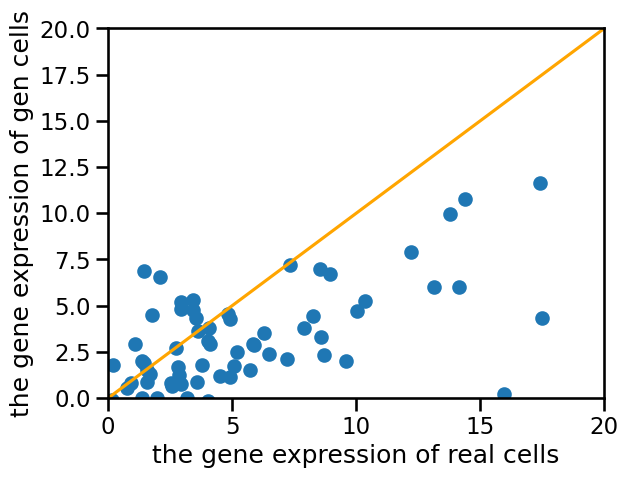

In [51]:
rna_seq = np.load('../outputs/samples_trans/babel_nocondi_layernorm_tfidt/20w_atac2rna_test_x10init_grad3/RNA_0.npz')['data']
atac_seq = np.load('../outputs/samples_trans/babel_nocondi_layernorm_tfidt/20w_rna2atac_test_x10init_grad3/ATAC_0.npz')['data']
rna_seq = rna_seq.reshape(times,-1,rna_seq.shape[-1]).mean(0)
atac_seq = atac_seq.reshape(times,-1,atac_seq.shape[-1]).mean(0)

split = 'test'
batch = {}
batch["X_norm"] = {'rna':torch.tensor(mdata['rna'][mdata['rna'].obs['batch']==split].X.toarray()),'atac':torch.tensor(mdata['atac'][mdata['rna'].obs['batch']==split].X.toarray())}

X = batch["X_norm"]['atac'].T.numpy()
nfreqs = 1.0 * X / np.tile(np.sum(X,axis=0), (X.shape[0],1))
X  = nfreqs * np.tile(np.log(1 + 1.0 * X.shape[1] / mdata['atac'][mdata['rna'].obs['batch']==split].var['n_counts'].values).reshape(-1,1), (1,X.shape[1]))
X = X.T #(cells, peaks)
# X = csr_matrix(X)
batch["X_norm"]['atac'] = torch.tensor(X)

z = encoder_model.encode(batch)
gen_rna_latent = rna_seq*rna_std#[mdata['rna'].obs['batch']==split]
gen_atac_latent = atac_seq*atac_std#[mdata['rna'].obs['batch']==split]

plt.figure()
lim = 20
plt.ylim((-0,lim))
plt.xlim((-0,lim))
plt.ylabel('the gene expression of gen cells')
plt.xlabel('the gene expression of real cells')
# plt.scatter(z['rna'].detach().numpy().mean(axis=0),gen_rna_latent.mean(axis=0))
plt.scatter(z['atac'].detach().numpy().mean(axis=0),gen_atac_latent.mean(axis=0))
plt.plot([0,lim],[0,lim],color='orange')

In [570]:
# read generated latent representation and decode back to gene expression/atac seq
# rna_seq = np.load('../outputs/samples_trans/babel_open_nocondi_ep39/40w_atac2rna_all/RNA_0.npz')['data']
# atac_seq = np.load('../outputs/samples_trans/babel_open_nocondi_ep39/40w_rna2atac_all/ATAC_0.npz')['data']
# type_index = np.load('../outputs/samples_trans/babel_open_nocondi_ep39/40w_rna2atac_all/RNA_0.npz')['label']
# rna_seq = np.load('../outputs/samples_trans/babel_open_nocondi_layernorm/60w_uncondi/RNA_0.npz')['data']
# atac_seq = np.load('../outputs/samples_trans/babel_open_nocondi_layernorm/60w_uncondi/ATAC_0.npz')['data']
# type_index = np.load('../outputs/samples_trans/babel_open_nocondi_layernorm/60w_uncondi/RNA_0.npz')['label']

rna_seq = np.load('../outputs/samples_trans/babel_nocondi_layernorm/80w_atac2rna_test_x5_grad3_640/RNA_0.npz')['data'] #80w_atac2rna_w12878_grad
atac_seq = np.load('../outputs/samples_trans/babel_nocondi_layernorm/80w_rna2atac_test_x5_grad3_640/ATAC_0.npz')['data']
type_index = np.load('../outputs/samples_trans/babel_nocondi_layernorm/80w_rna2atac_test_x5_grad3_640/RNA_0.npz')['label']
# rna_seq = np.load('../outputs/samples_trans/babel_nocondi_layernorm_catlinear/80w_atac2rna_test_x5_grad3_640/RNA_0.npz')['data']
# atac_seq = np.load('../outputs/samples_trans/babel_nocondi_layernorm_catlinear/80w_rna2atac_test_x5_grad3_640/ATAC_0.npz')['data']
# type_index = np.load('../outputs/samples_trans/babel_nocondi_layernorm_catlinear/80w_rna2atac_test_x5_grad3_640/RNA_0.npz')['label']
# times = 5
# rna_seq = rna_seq.reshape(times,-1,rna_seq.shape[-1])[0]#.mean(0)
# atac_seq = atac_seq.reshape(times,-1,atac_seq.shape[-1])[0]#.mean(0)
# type_index = type_index[:rna_seq.shape[0]]

npzfile = np.load('/'.join(ae_path.split('/')[:-2])+'/norm_factor.npz')
rna_std = npzfile['rna_std']
atac_std = npzfile['atac_std']
z = {'rna':torch.tensor(rna_seq*rna_std).squeeze(1),'atac':torch.tensor(atac_seq*atac_std).squeeze(1)}     # open  layernorm

size_factor = get_size_factor(torch.tensor(type_index,dtype=torch.int))  # cell type average
# size_factor = {'rna':torch.tensor(mdata_rna.X.toarray().sum(1)).unsqueeze(-1)} # ground truth

mean = torch.ones(rna_seq.shape[0])*size_factor_statistics["mean"][covariate_keys][:-1].mean()  # average
std = torch.ones(rna_seq.shape[0])*size_factor_statistics["sd"][covariate_keys][:-1].mean()
# mean = torch.ones(real_cell.shape[0])* size_factor_statistics["mean"][covariate_keys][type_index].mean()  # average
# std = torch.ones(real_cell.shape[0])*size_factor_statistics["sd"][covariate_keys][type_index].mean()
size_factor_dist = Normal(loc=mean, scale=std)
log_size_factor_mean = size_factor_dist.sample().view(-1, 1)
size_factor_mean = torch.exp(log_size_factor_mean)

# size_factor['rna'][-real_cell.shape[0]:] = torch.exp(torch.ones(real_cell.shape[0]).unsqueeze(-1)*size_factor_statistics["mean"][covariate_keys][:-1].mean())
# size_factor['rna'][mdata['rna'].obs['batch']=='test'] = torch.exp(torch.ones((mdata['rna'].obs['batch']=='test').sum()).unsqueeze(-1)*size_factor_statistics["mean"][covariate_keys][:-1].mean())
# size_factor['rna'][mdata['rna'].obs['batch']=='val'] = torch.exp(torch.ones((mdata['rna'].obs['batch']=='val').sum()).unsqueeze(-1)*size_factor_statistics["mean"][covariate_keys][:-1].mean())

# size_factor['rna'] = torch.exp(torch.ones(rna_seq.shape[0]).unsqueeze(-1)*size_factor_statistics["mean"][covariate_keys][:-1].mean())
size_factor['rna'] = size_factor_mean#.repeat(5,1)#.squeeze(-1)

mu_hat = encoder_model.decode(z, size_factor)

# mu_hat['rna'] = mu_hat['rna'].reshape(times,-1,mu_hat['rna'].shape[-1]).mean(0)
# mu_hat['atac'] = mu_hat['atac'].reshape(times,-1,mu_hat['atac'].shape[-1]).mean(0)

sample = {}  # containing final samples 
for mod in mu_hat:
    if mod=="rna":  
        # if not self.covariate_specific_theta:
        distr = NegativeBinomial(mu=mu_hat[mod], theta=torch.exp(encoder_model.theta))
        # else:
        #     distr = NegativeBinomial(mu=mu_hat[mod], theta=torch.exp(encoder_model.theta[covariate_indices[theta_covariate]]))
    else:  # if mod is atac
        if not encoder_model.is_binarized:
            distr = Poisson(rate=mu_hat[mod])
        else:
            distr = Bernoulli(probs=mu_hat[mod])
    sample[mod] = distr.sample() 

# reconstruct = sample['rna'][mdata['rna'].obs['batch']!='12878'].detach().numpy()[::3]
# reconstruct2 = sample['atac'][mdata['atac'].obs['batch']!='12878'].detach().numpy()[::3]
# reconstruct = sample['rna'][type_index==3][:real_cell.shape[0]].detach().numpy()
# reconstruct2 = sample['atac'][type_index==3][:real_cell.shape[0]].detach().numpy()

reconstruct =  sample['rna'].detach().numpy()#[:2004]#.reshape(times,-1,sample['rna'].shape[-1]).mean(0) # sample['rna'].detach().numpy()
reconstruct2 = sample['atac'].detach().numpy()#[:2004]#.reshape(times,-1,sample['atac'].shape[-1]).mean(0) # sample['atac'].detach().numpy()
# reconstruct2 = (reconstruct2.sum(0)>3).astype(np.float32)

reconstruct.shape, reconstruct2.shape

((10020, 34861), (10020, 223897))

In [571]:
# cell filter one split
val_gen_cells = reconstruct
real_size = (mdata_rna.obs['batch']=='test').sum() #val_gen_cells[::3].shape[0]

dis = np.linalg.norm((val_gen_cells-val_gen_cells.mean(axis=0)),axis=1)
# find all the index where dis is smaller than 100
filtered_indices = np.where(dis<np.median(dis))[0]
reconstruct = val_gen_cells[filtered_indices][:real_size]

# val_gen_cells = reconstruct2
# dis = np.linalg.norm((val_gen_cells-val_gen_cells.mean(axis=0)),axis=1)
# # find all the index where dis is smaller than 100
# filtered_indices = np.where(dis<np.median(dis))[0]
reconstruct2 = reconstruct2[filtered_indices][:real_size]
reconstruct2.shape,reconstruct.shape

((2004, 223897), (2004, 34861))

In [13]:
#cell filter multi split
gen_split = []
reconstruct = []
reconstruct2 = []

for sp in ['val','test']:
    val_gen_cells = sample['rna'][mdata['rna'].obs['batch']==sp].detach().numpy()
    val_atac_cells = sample['atac'][mdata['atac'].obs['batch']==sp].detach().numpy()
    real_size = (mdata_rna.obs['batch']==sp).sum() #val_gen_cells[::3].shape[0]

    #cell filter
    dis = np.linalg.norm((val_gen_cells-val_gen_cells.mean(axis=0)),axis=1)
    # find all the index where dis is smaller than 100
    filtered_indices = np.where(dis<np.median(dis))[0] # np.where(dis<dis.max()*0.1)[0] #

    filtered_cells = val_gen_cells[filtered_indices][:real_size]
    filtered_cells_atac = val_atac_cells[filtered_indices][:real_size]
    reconstruct.append(filtered_cells)
    reconstruct2.append(filtered_cells_atac)
    gen_split+=[sp]*filtered_cells.shape[0]

train_size = (mdata_rna.obs['batch']=='train').sum()
reconstruct.append(sample['rna'][mdata['rna'].obs['batch']=='train'].detach().numpy()[:train_size])
reconstruct2.append(sample['atac'][mdata['atac'].obs['batch']=='train'].detach().numpy()[:train_size])
gen_split+=['train']*sample['rna'][mdata['rna'].obs['batch']=='train'].detach().numpy()[:train_size].shape[0]
reconstruct = np.concatenate(reconstruct,axis=0)
reconstruct2 = np.concatenate(reconstruct2,axis=0)
reconstruct.shape,reconstruct2.shape

((11090, 34861), (11090, 223897))

In [572]:
real_cell = norm_total(real_cell)
reconstruct = norm_total(reconstruct)

# real_cell2 = norm_total(real_cell2)
# reconstruct2 = norm_total(reconstruct2)

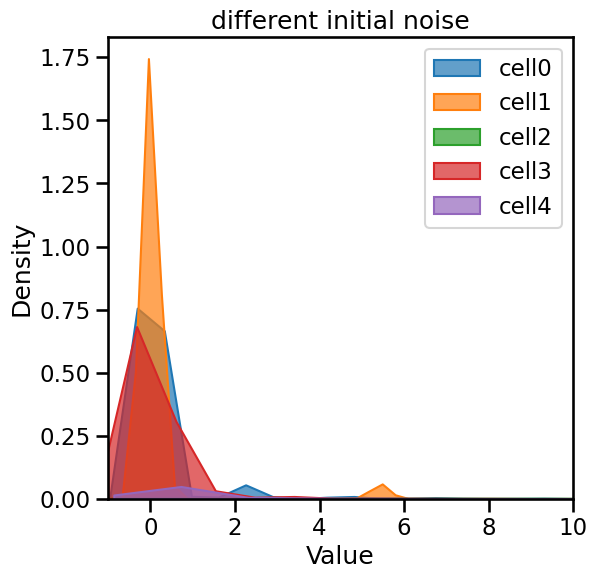

In [199]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

generated = reconstruct[2::10]

# 创建图形
plt.figure(figsize=(6, 6))

# 绘制真实细胞的数据分布
for i in range(5):
    sns.kdeplot(generated[i], fill=True, label=f'cell{i}', alpha=0.7)
    # plt.hist(generated[i], bins=60, alpha=0.7, density=True)
plt.xlim([-1,10])

# 添加图例
plt.legend()

# 添加标签和标题
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('different initial noise')

# 显示图形
plt.show()


# BABEL translated

In [37]:
# babel testset
# real_cell = sc.read_h5ad('/stor/lep/workspace/multi_diffusion/babel-main/output/cv_logsplit_01_model_only/truth_rna.h5ad').X.toarray()
# real_cell2 = sc.read_h5ad('/stor/lep/workspace/multi_diffusion/babel-main/output/cv_logsplit_01_model_only/truth_atac.h5ad').X.toarray()
# reconstruct = sc.read_h5ad('/stor/lep/workspace/multi_diffusion/babel-main/output/cv_logsplit_01_model_only/atac_rna_adata.h5ad').X.toarray()
# reconstruct2 = sc.read_h5ad('/stor/lep/workspace/multi_diffusion/babel-main/output/cv_logsplit_01_model_only/rna_atac_adata.h5ad').X.toarray()

real_cell = sc.read_h5ad('/stor/lep/workspace/multi_diffusion/babel-main/output/my_model/truth_rna.h5ad').X.toarray()
real_cell2 = sc.read_h5ad('/stor/lep/workspace/multi_diffusion/babel-main/output/my_model/truth_atac.h5ad').X.toarray()
reconstruct = sc.read_h5ad('/stor/lep/workspace/multi_diffusion/babel-main/output/my_model/atac_rna_test_preds.h5ad').X.toarray()
reconstruct2 = sc.read_h5ad('/stor/lep/workspace/multi_diffusion/babel-main/output/my_model/rna_atac_test_preds.h5ad').X.toarray()

# real_cell = sc.read_h5ad('/stor/lep/workspace/multi_diffusion/babel-main/output/openproblem/truth_rna.h5ad').X.toarray()
# real_cell2 = sc.read_h5ad('/stor/lep/workspace/multi_diffusion/babel-main/output/openproblem/truth_atac.h5ad').X.toarray()
# reconstruct = sc.read_h5ad('/stor/lep/workspace/multi_diffusion/babel-main/output/openproblem/atac_rna_test_preds.h5ad').X.toarray()
# reconstruct2 = sc.read_h5ad('/stor/lep/workspace/multi_diffusion/babel-main/output/openproblem/rna_atac_test_preds.h5ad').X.toarray()

real_cell = norm_total(real_cell)
reconstruct = norm_total(reconstruct)

# real_cell2 = norm_total(real_cell2)
# reconstruct2 = norm_total(reconstruct2)
distr = Bernoulli(probs=torch.tensor(reconstruct2))
reconstruct2 = distr.sample().numpy() 

real_cell.shape,reconstruct.shape

/home/lep/miniconda3/envs/mm-diffusion/lib/python3.8/site-packages/anndata/_io/h5ad.py:238: OldFormatWarning: Element '/X' was written without encoding metadata.
  d[k] = read_elem(f[k])
/home/lep/miniconda3/envs/mm-diffusion/lib/python3.8/site-packages/anndata/_io/h5ad.py:238: OldFormatWarning: Element '/layers' was written without encoding metadata.
  d[k] = read_elem(f[k])
/home/lep/miniconda3/envs/mm-diffusion/lib/python3.8/site-packages/anndata/_io/specs/methods.py:92: OldFormatWarning: Element '/layers/row_counts' was written without encoding metadata.
  return {k: read_elem(v) for k, v in elem.items()}
/home/lep/miniconda3/envs/mm-diffusion/lib/python3.8/site-packages/anndata/_io/h5ad.py:279: OldFormatWarning: '/obs' was written with a very old version of AnnData. Consider rewriting it.
  warn(
/home/lep/miniconda3/envs/mm-diffusion/lib/python3.8/site-packages/anndata/_io/h5ad.py:238: OldFormatWarning: Element '/obsm' was written without encoding metadata.
  d[k] = read_elem(f[k

((2004, 34861), (2004, 34861))

# evaluation

In [573]:
print('RNA')
print(real_cell.mean())
print(reconstruct.mean())
# print('spearman=',stats.spearmanr(real_cell.flatten(), reconstruct.flatten()).correlation)
# print('pearson=',np.corrcoef(real_cell.flatten(), reconstruct.flatten())[0][1])
print('spearman bulk=',stats.spearmanr(real_cell.mean(axis=0), reconstruct.mean(axis=0)).correlation)
print('pearson bulk=',np.corrcoef(real_cell.mean(axis=0), reconstruct.mean(axis=0))[0][1])
# print('MSE=',np.mean((reconstruct-real_cell)**2))
# print('L2 Norm=',np.linalg.norm(reconstruct.mean(axis=0)-real_cell.mean(axis=0)))

print('\nATAC')
print(real_cell2.mean())
print(reconstruct2.mean())
# print('spearman=',stats.spearmanr(real_cell2.flatten(), reconstruct2.flatten()).correlation)
# print('pearson=',np.corrcoef(real_cell2.flatten(), reconstruct2.flatten())[0][1])
print('spearman mean=',stats.spearmanr(real_cell2.mean(axis=0), reconstruct2.mean(axis=0)).correlation)
print('pearson mean=',np.corrcoef(real_cell2.mean(axis=0), reconstruct2.mean(axis=0))[0][1])
# print('MSE=',np.mean((reconstruct2-real_cell2)**2))
# print('L2 Norm=',np.linalg.norm(reconstruct2.mean(axis=0)-real_cell2.mean(axis=0)))

RNA
0.28685427
0.28685337
spearman bulk= 0.9594979170292072
pearson bulk= 0.9889895624387205

ATAC
0.0183027
0.01575214
spearman mean= 0.9326336652366016
pearson mean= 0.963483306383864


In [ ]:
import sklearn.metrics as metrics

print('AUROC for ATAC data')
truth = real_cell2.flatten()
# preds = mu_hat['atac'][mdata['atac'].obs['batch']=='12878'].detach().numpy().flatten()
preds = mu_hat['atac'].detach().numpy()[filtered_indices][:real_size].flatten()#[::8].reshape(5,-1,mu_hat['atac'].shape[-1]).mean(0)
# preds = reconstruct2.flatten()
fpr, tpr, _thresholds = metrics.roc_curve(truth, preds)
auc = metrics.auc(fpr, tpr)
print(auc)

AUROC for ATAC data
0.7761632320027573


In [99]:
print('RNA')
adata = np.concatenate((real_cell, reconstruct),axis=0)
adata = ad.AnnData(adata, dtype=np.float32)
adata.obs_names = [f"true_Cell" for i in range(real_cell.shape[0])]+[f"gen_Cell" for i in range(reconstruct.shape[0])]
sc.tl.pca(adata, svd_solver='arpack')
adata.obs['batch'] = pd.Categorical([f"true_Cell" for i in range(real_cell.shape[0])]+[f"gen_Cell" for i in range(reconstruct.shape[0])])
print('MMD = ', MMD(adata))
print('LISI = ', LISI(adata))
# print('AUC = ', random_forest(adata))

print('\nATAC')
adata = np.concatenate((real_cell2, reconstruct2),axis=0)
adata = ad.AnnData(adata, dtype=np.float32)
adata.obs_names = [f"true_Cell" for i in range(real_cell2.shape[0])]+[f"gen_Cell" for i in range(reconstruct2.shape[0])]
sc.tl.pca(adata, svd_solver='arpack')
adata.obs['batch'] = pd.Categorical([f"true_Cell" for i in range(real_cell2.shape[0])]+[f"gen_Cell" for i in range(reconstruct2.shape[0])])
print('MMD = ', MMD(adata))
print('LISI = ', LISI(adata))
# print('AUC = ', random_forest(adata))

RNA


100%|██████████| 21/21 [00:01<00:00, 13.11it/s]


MMD =  tensor(0.2778)
LISI =  0.5072966162160852

ATAC


100%|██████████| 21/21 [00:01<00:00, 13.38it/s]


MMD =  tensor(0.2001)
LISI =  0.6528523083505289


In [39]:
from sklearn.metrics import precision_score, recall_score

y_true = reconstruct2[4]
y_pred = real_cell2[4]

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print("Precision:", precision)
print("Recall:", recall)

Precision: 0.056129638327853455
Recall: 0.08221534227726178


In [33]:
import numpy as np

def overall_jaccard_similarity(data_a, data_b):
    # 计算交集和并集
    intersection = np.sum(data_a & data_b)  # 交集
    union = np.sum(data_a | data_b)        # 并集
    # 计算 Jaccard 相似度
    if union > 0:
        return intersection / union
    else:
        return 0.0  # 如果并集为0，返回相似度为0

data_a = reconstruct2.astype(np.int)
# data_a = real_cell2.astype(np.int)
data_b = real_cell2.astype(np.int)

# 计算整体 Jaccard 相似度
similarity = overall_jaccard_similarity(data_a, data_b)
print(f"Overall Jaccard Similarity: {similarity:.4f}")

Overall Jaccard Similarity: 0.0359


In [48]:
import numpy as np

def cosine_similarity(vec_a, vec_b):
    # 将输入转换为 NumPy 数组并确保为浮点型
    vec_a = np.asarray(vec_a, dtype=np.float32)
    vec_b = np.asarray(vec_b, dtype=np.float32)

    # 计算点积
    dot_product = np.dot(vec_a, vec_b)

    # 计算范数（模）
    norm_a = np.linalg.norm(vec_a)
    norm_b = np.linalg.norm(vec_b)

    # 计算余弦相似性
    if norm_a > 0 and norm_b > 0:
        return dot_product / (norm_a * norm_b)
    else:
        return 0.0  # 如果任一向量的范数为0，返回相似性为0

# 示例数据
vec_a = reconstruct2[3]#.mean(0)
vec_b = real_cell2[3]#.mean(0)

# 计算余弦相似性
similarity = cosine_similarity(vec_a, vec_b)
print(f"Cosine Similarity: {similarity:.4f}")


Cosine Similarity: 0.0519


In [65]:
def overall_overlap_coefficient(data_a, data_b):
    # 确保输入为 NumPy 数组和整型
    data_a = np.asarray(data_a, dtype=np.int8)
    data_b = np.asarray(data_b, dtype=np.int8)

    # 计算交集的大小
    intersection = np.sum(data_a & data_b)
    
    # 计算每个集合的大小
    size_a = np.sum(data_a)
    size_b = np.sum(data_b)

    # 计算重叠系数
    min_size = min(size_a, size_b)
    
    if min_size > 0:
        return intersection / min_size
    else:
        return 0.0  # 如果最小集合大小为0，返回相似度为0

data_a = reconstruct2.mean(0)
data_b = real_cell2.mean(0)

# 计算整体重叠系数
overlap_coefficient = overall_overlap_coefficient(data_a, data_b)
print(f"Overall Overlap Coefficient: {overlap_coefficient:.4f}")

Overall Overlap Coefficient: 0.0000


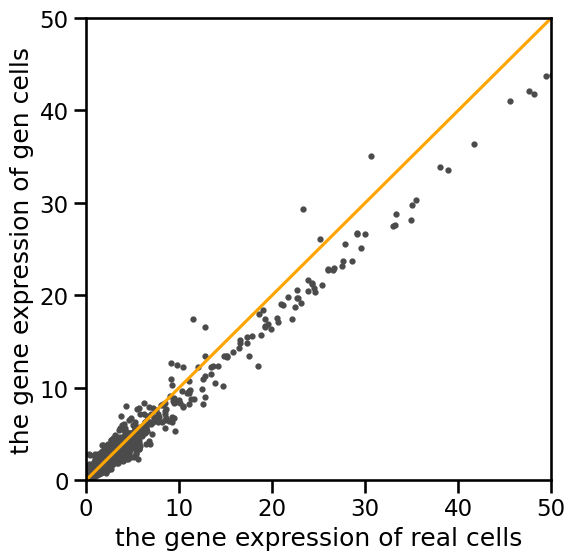

In [583]:
plt.figure(figsize=(6,6))
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
lim = 50
plt.ylim((-0,lim))
plt.xlim((-0,lim))
plt.ylabel('the gene expression of gen cells')
plt.xlabel('the gene expression of real cells')
plt.scatter(real_cell.mean(axis=0),reconstruct.mean(axis=0),s=9,color='#4B4B4B')
# plt.scatter(np.expm1(cell_data).mean(axis=0),np.expm1(cell_gen).mean(axis=0))
plt.plot([0,lim],[0,lim],color='orange')
plt.savefig(f'/stor/lep/workspace/multi_diffusion/MM-Diffusion/evaluate_script/figures/translation/babel_rna_test_scatter.pdf')

In [580]:
k, b = np.polyfit(real_cell.mean(axis=0), reconstruct.mean(axis=0), 1)
k,b

(0.8973994582405175, 0.02943133864490693)

In [ ]:
(0.7691803745111593, 0.06621143454468251)
(0.9012225874971713, 0.02833464889592095)

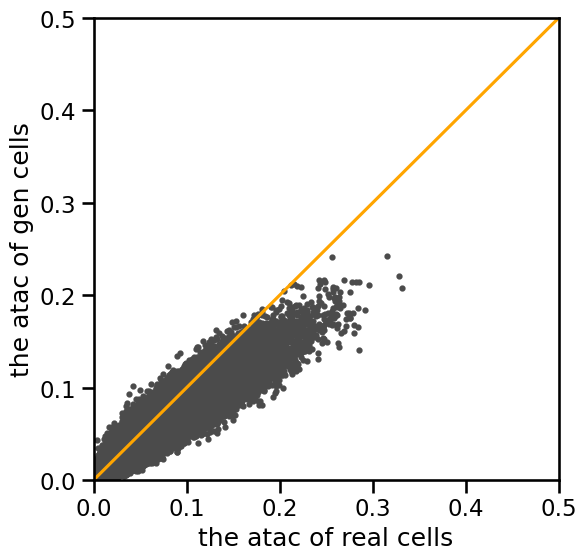

In [582]:
plt.figure(figsize=(6,6))
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
lim = 0.5
plt.ylim((-0,lim))
plt.xlim((-0,lim))
plt.ylabel('the atac of gen cells')
plt.xlabel('the atac of real cells')
plt.scatter(real_cell2.mean(axis=0),reconstruct2.mean(axis=0),s=9,color='#4B4B4B')
# plt.scatter(np.expm1(cell_data).mean(axis=0),np.expm1(cell_gen).mean(axis=0))
plt.plot([0,lim],[0,lim],color='orange')
plt.savefig(f'/stor/lep/workspace/multi_diffusion/MM-Diffusion/evaluate_script/figures/translation/babel_atac_test_scatter.pdf')

In [79]:
k, b = np.polyfit(real_cell2.mean(axis=0), reconstruct2.mean(axis=0), 1)
k,b

(0.790369371079435, 0.0012541145724231032)

In [ ]:
(1.1961351507809488, -0.001249579171133508)
(0.7961226754617994, 0.0012783507798139963)

In [15]:
adata = np.concatenate((real_cell, reconstruct),axis=0)
adata = ad.AnnData(adata, dtype=np.float32)
# adata.var_names = gene_names
adata.obs['cell_name'] = [f"true_Cell" for i in range(real_cell.shape[0])]+[f"gen_Cell" for i in range(reconstruct.shape[0])]
adata.obs['split'] = [item+'_real' for item in mdata_rna.obs['batch'].values]+[item+'_gen' for item in mdata_rna.obs['batch'].values]#gen_split

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [ ]:
adata[np.in1d(adata.obs['split'].values,['train_real','train_gen'])]

View of AnnData object with n_obs × n_vars = 1934 × 34861
    obs: 'cell_name', 'split'
    uns: 'log1p'

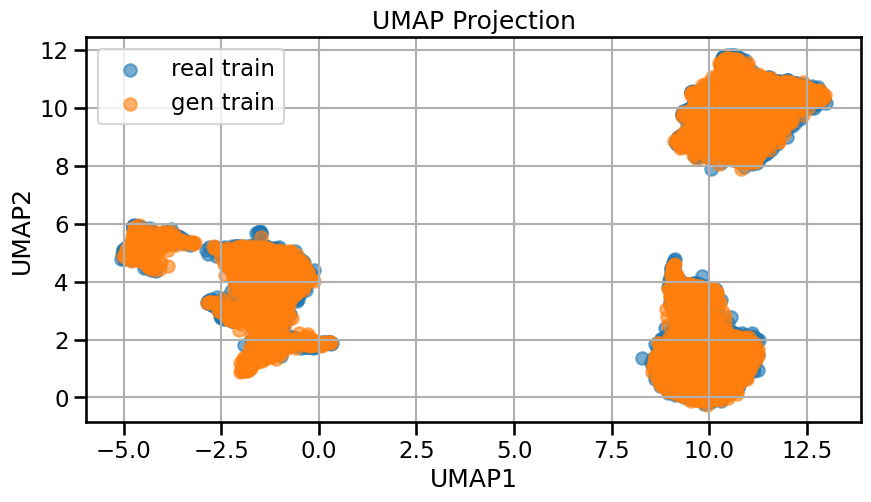

In [18]:
import umap
# 创建 UMAP 对象并对第一批数据进行拟合并变换
adata = np.concatenate((real_cell, reconstruct),axis=0)
adata = ad.AnnData(adata, dtype=np.float32)
# adata.var_names = gene_names
adata.obs['cell_name'] = [f"true_Cell" for i in range(real_cell.shape[0])]+[f"gen_Cell" for i in range(reconstruct.shape[0])]
adata.obs['split'] = [item+'_real' for item in mdata_rna.obs['batch'].values]+[item+'_gen' for item in mdata_rna.obs['batch'].values]#gen_split

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean')
embedding1 = umap_model.fit_transform(adata[np.in1d(adata.obs['split'].values,['train_real','train_gen'])].X.toarray())

# 将第二批数据映射到第一批数据的 UMAP 空间
embedding2 = umap_model.transform(adata[np.in1d(adata.obs['split'].values,['test_real','test_gen'])].X.toarray())

# 绘制 UMAP 图
plt.figure(figsize=(10, 5))
plt.scatter(embedding1[:int(embedding1.shape[0]/2), 0], embedding1[:int(embedding1.shape[0]/2), 1], label='real train', alpha=0.6,)
plt.scatter(embedding1[int(embedding1.shape[0]/2):, 0], embedding1[int(embedding1.shape[0]/2):, 1], label='gen train', alpha=0.6,)
plt.scatter(embedding2[:, 0], embedding2[:, 1], label='gen test', alpha=0.6, color='gray')
plt.title('UMAP Projection')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend()
plt.grid()
plt.show()

sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x72c8abfa9d00>


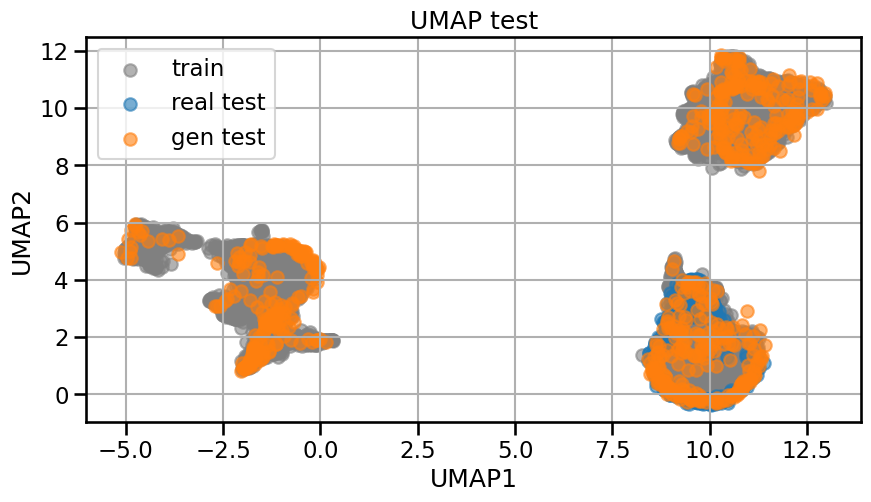

In [19]:
# 绘制 UMAP 图
plt.figure(figsize=(10, 5))
plt.scatter(embedding1[:, 0], embedding1[:, 1], label='train', alpha=0.6, color='gray')
plt.scatter(embedding2[:int(embedding2.shape[0]/2), 0], embedding2[:int(embedding2.shape[0]/2), 1], label='real test', alpha=0.6,)
plt.scatter(embedding2[int(embedding2.shape[0]/2):, 0], embedding2[int(embedding2.shape[0]/2):, 1], label='gen test', alpha=0.6,)
plt.title('UMAP test')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend()
plt.grid()
plt.show()

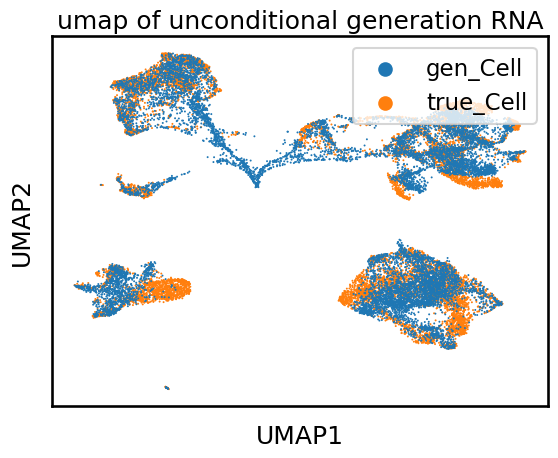

In [366]:
# # 再转回anndata便于scanpy处理
adata = np.concatenate((real_cell, reconstruct),axis=0)
adata = ad.AnnData(adata, dtype=np.float32)
# adata.var_names = gene_names
adata.obs['cell_name'] = [f"true_Cell" for i in range(real_cell.shape[0])]+[f"gen_Cell" for i in range(reconstruct.shape[0])]
adata.obs['split'] = [item+'_real' for item in mdata_rna.obs['batch'].values]+[item+'_gen' for item in mdata_rna.obs['batch'].values]#gen_split

# adata.obs['cell_type'] = list(mdata['rna'].obs['cell_type'][:69000:10].to_numpy())+['gen_cell']*reconstruct.shape[0]

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
# adata.raw = adata
# adata = adata[:, adata.var.highly_variable]

# sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=15)
sc.tl.umap(adata,        
        maxiter=500,
        min_dist=0.3,  # Seurat default is 0.3, scanpy is 0.5
        spread=1.0,  # Seurat default is 1.0
        alpha=1.0,  # Seurat default starting learning rate is 1.0
        gamma=1.0,  # Seurate default repulsion strength is 1.0
        negative_sample_rate=5,  # Seurat default negative sample rate is 5
    )
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

sc.pl.umap(adata, color='cell_name', size=8, title='umap of unconditional generation RNA', show=False)
plt.legend(loc = 'upper right')
# plt.savefig(f'/data1/lep/Workspace/guided-diffusion/figure_pdf_new/pbmc_umap_uncondi.pdf')

/home/lep/miniconda3/envs/mm-diffusion/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/lep/miniconda3/envs/mm-diffusion/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/lep/miniconda3/envs/mm-diffusion/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


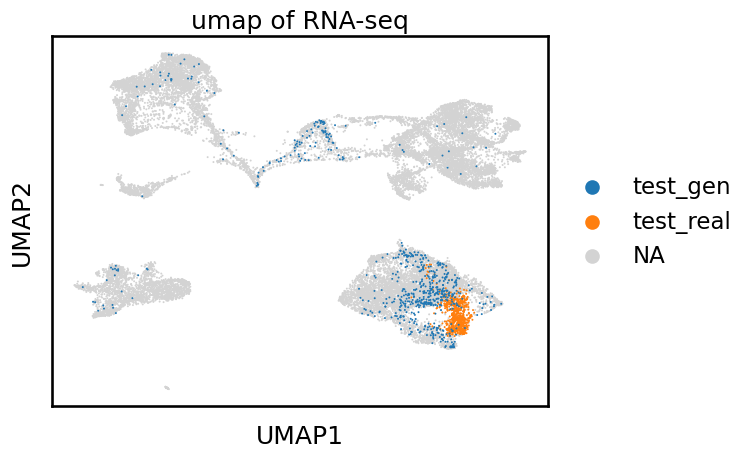

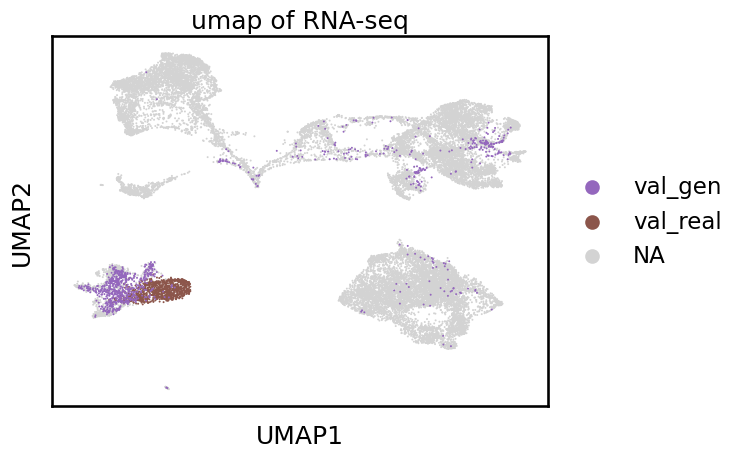

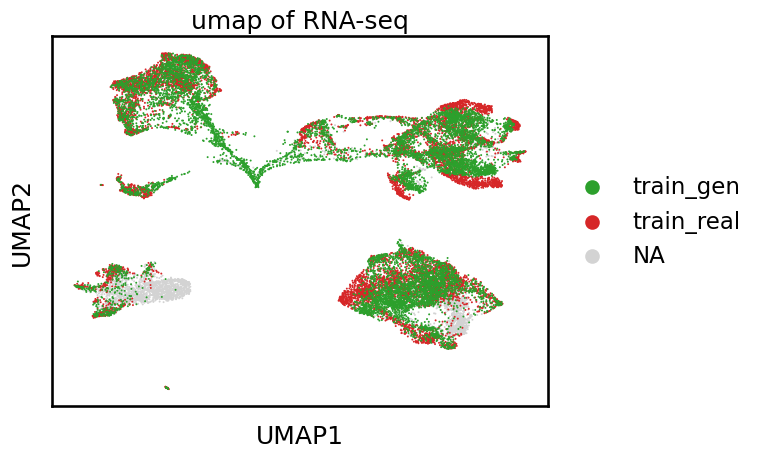

In [367]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
sc.pl.umap(adata, color='split', groups=['test_real','test_gen'], size=8, title='umap of RNA-seq', show=False)
plt.savefig(f'/stor/lep/workspace/multi_diffusion/MM-Diffusion/evaluate_script/figures/translation/babel_test_umap_nofilter.pdf')
sc.pl.umap(adata, color='split', groups=['val_real','val_gen'], size=8, title='umap of RNA-seq', show=False)
plt.savefig(f'/stor/lep/workspace/multi_diffusion/MM-Diffusion/evaluate_script/figures/translation/babel_valid_umap_nofilter.pdf')
# sc.pl.umap(adata, color='split', groups=['12878_real','12878_gen'], size=8, title='umap of RNA-seq', show=False)
sc.pl.umap(adata, color='split', groups=['train_real','train_gen'], size=8, title='umap of RNA-seq', show=False)
plt.savefig(f'/stor/lep/workspace/multi_diffusion/MM-Diffusion/evaluate_script/figures/translation/babel_train_umap_nofilter.pdf')

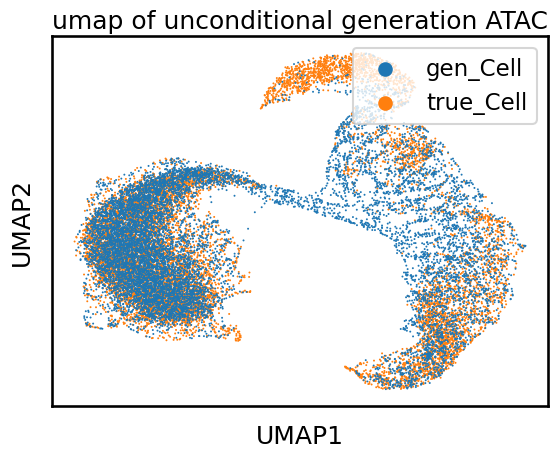

In [363]:
# # 再转回anndata便于scanpy处理
adata = np.concatenate((real_cell2, reconstruct2),axis=0)
adata = ad.AnnData(adata, dtype=np.float32)
# adata.var_names = gene_names
adata.obs['cell_name'] = [f"true_Cell" for i in range(real_cell2.shape[0])]+[f"gen_Cell" for i in range(reconstruct2.shape[0])]
adata.obs['split'] = [item+'_real' for item in mdata_rna.obs['batch'].values]+[item+'_gen' for item in mdata_rna.obs['batch'].values] #gen_split

sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)

# sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
# adata.raw = adata
# adata = adata[:, adata.var.highly_variable]

# sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

sc.pl.umap(adata, color='cell_name', size=8, title='umap of unconditional generation ATAC', show=False)
plt.legend(loc = 'upper right')

/home/lep/miniconda3/envs/mm-diffusion/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/lep/miniconda3/envs/mm-diffusion/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/lep/miniconda3/envs/mm-diffusion/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


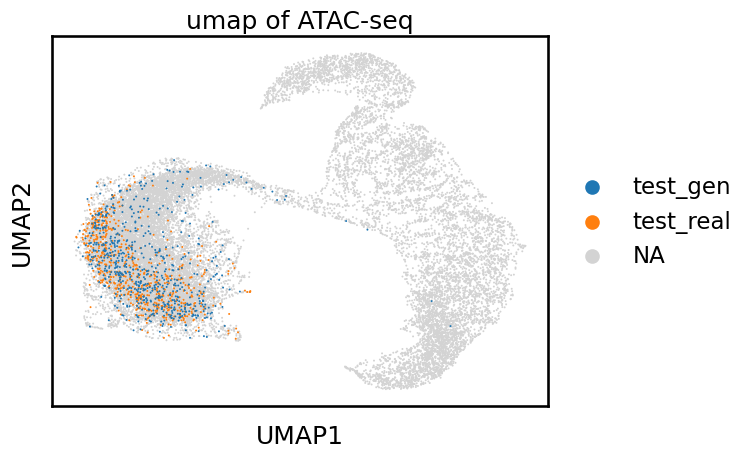

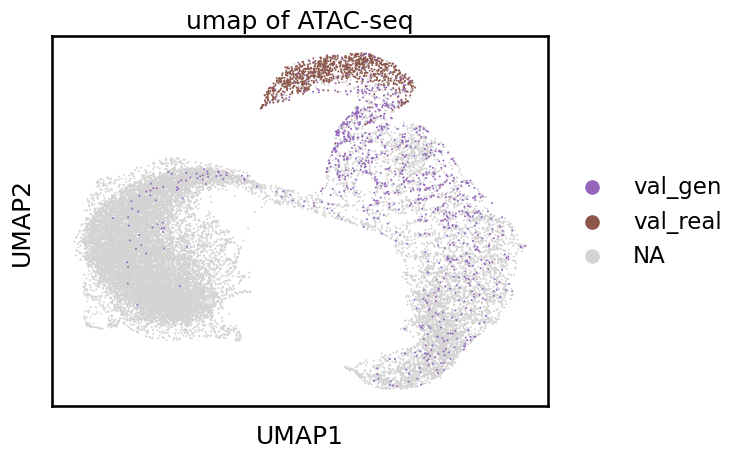

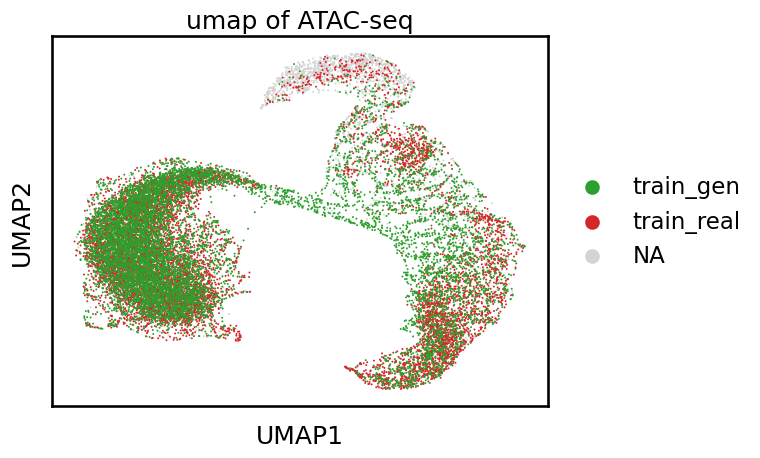

In [365]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
sc.pl.umap(adata, color='split', groups=['test_real','test_gen'], size=8, title='umap of ATAC-seq', show=False)
plt.savefig(f'/stor/lep/workspace/multi_diffusion/MM-Diffusion/evaluate_script/figures/translation/babel_atac_test_umap_nofilter.pdf')
sc.pl.umap(adata, color='split', groups=['val_real','val_gen'], size=8, title='umap of ATAC-seq', show=False)
plt.savefig(f'/stor/lep/workspace/multi_diffusion/MM-Diffusion/evaluate_script/figures/translation/babel_atac_valid_umap_nofilter.pdf')
# sc.pl.umap(adata, color='split', groups=['12878_real','12878_gen'], size=8, title='umap of RNA-seq', show=False)
sc.pl.umap(adata, color='split', groups=['train_real','train_gen'], size=8, title='umap of ATAC-seq', show=False)
plt.savefig(f'/stor/lep/workspace/multi_diffusion/MM-Diffusion/evaluate_script/figures/translation/babel_atac_train_umap_nofilter.pdf')

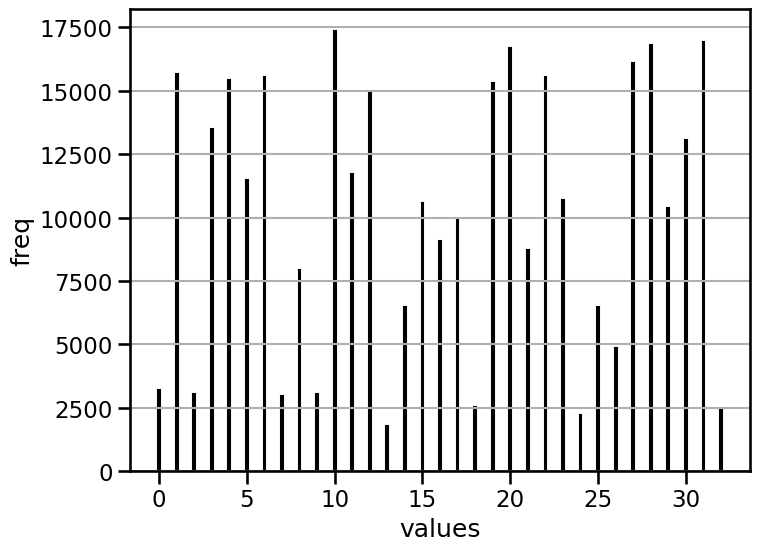

In [ ]:
plt.figure(figsize=(8, 6))
# 为了更好地展示浮点数，我们可以增加bins的数量
# plt.hist(torch.exp(size_factor_statistics["mean"]['leiden']).squeeze(-1), bins=200, edgecolor='black')
plt.bar(range(33), torch.exp(size_factor_statistics["mean"]['leiden']).squeeze(-1), width=0.1, edgecolor='black')
# plt.title('浮点数值分布柱状图')
# plt.xlim(0,200000)
plt.xlabel('values')
plt.ylabel('freq')
plt.grid(axis='y')

# 显示图表
plt.show()

draw plot

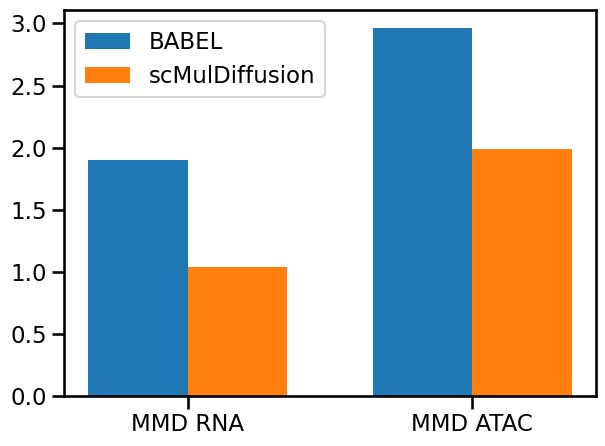

: 

In [298]:
# test_cluster = [[0.96632,0.96740,1.5305,0.04867,0.96471,0.97239,0.3295,0.31386],
#         [0.98861,0.95554,0.2985,0.55186,0.96426,0.93345,0.1849,0.64446],]

# gm12878 = [[0.86374,0.83644,1.8956,0.28457,0.31972,2.9607],
#            [0.85872,0.81060,1.0359,0.45713,0.45215,1.9915]]

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# array1 = [0.96632, 0.96740, 1.5305, 0.04867, 0.96471, 0.97239, 0.3295, 0.31386]
# array2 = [0.98861, 0.95554, 0.2985, 0.55186, 0.96426, 0.93345, 0.1849, 0.64446]
array1 = [1.8956,  2.9607,]
array2 = [1.0359,  1.9915,]

# 生成x轴坐标
x = np.arange(len(array1))#  # 生成0到n-1的整数序列，n为array1的长度

# 设置柱子的宽度
width = 0.35  

# 创建柱状图
fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, array1, width, label='BABEL')
bars2 = ax.bar(x + width/2, array2, width, label='scMulDiffusion')

# 添加一些文本以进行标注
# ax.set_xlabel('Index')
# ax.set_ylabel('Values')
# ax.set_title('Comparison of Array 1 and Array 2')
ax.set_xticks(x)
# ax.set_xticklabels(['PCC RNA','SCC RNA','MMD RNA','LISI RNA','PCC ATAC','SCC ATAC','MMD ATAC','LISI ATAC'])  # 设置x轴的标签[str(i) for i in range(len(array1))]
ax.set_xticklabels(['MMD RNA','MMD ATAC',])
ax.legend()
# plt.ylim((0.5,1.0))

# 显示图形
plt.tight_layout()
# plt.show()
plt.savefig(f'/stor/lep/workspace/multi_diffusion/MM-Diffusion/evaluate_script/figures/translation/metrics_12878_MMD.pdf')

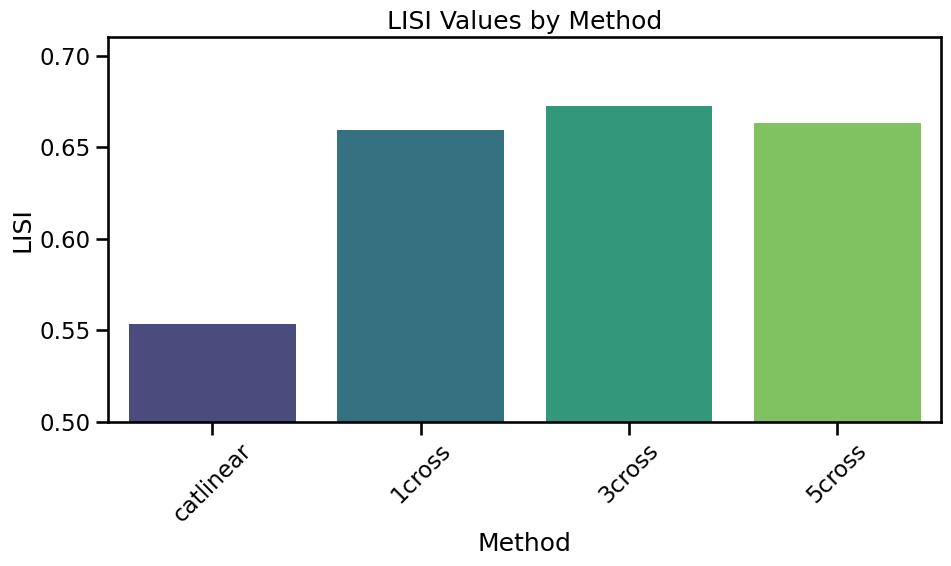

In [508]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 创建 DataFrame
key_name = 'LISI'
data = {
    'Method': ['catlinear', '1cross', '3cross', '5cross'],
    # key_name:    [0.2795,0.2846,0.2592,0.2475]
    # key_name:    [0.1801,0.1915,0.1849,0.1796]
    # key_name:    [0.54919,0.49334,0.55186,0.59084]
    key_name:    [0.55368,0.65962,0.67255,0.66314]
}

df = pd.DataFrame(data)

# 用 NaN 替代缺失值
df[key_name] = df[key_name].fillna(0)  # 或者您可以选择删除缺失值或使用其他处理方法

# 绘制柱状图
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.figure(figsize=(10, 6))
sns.barplot(x='Method', y=key_name, data=df, palette='viridis')

# 设置标题和标签
plt.title(f'{key_name} Values by Method')
plt.xlabel('Method')
plt.ylabel(key_name)
plt.xticks(rotation=45)  # 旋转 x 轴标签
plt.ylim(0.5, 0.71)  # 确保y轴范围在0到1之间

# 显示图形
plt.tight_layout()
# plt.show()
plt.savefig(f'/stor/lep/workspace/multi_diffusion/MM-Diffusion/evaluate_script/figures/translation/ablation_LISI_atac.pdf')

# marker gene violin plot

In [584]:
babel = sc.read_h5ad('/stor/lep/workspace/multi_diffusion/babel-main/output/my_model/atac_rna_test_preds.h5ad').X.toarray()
babel = norm_total(babel)

/home/lep/miniconda3/envs/mm-diffusion/lib/python3.8/site-packages/anndata/_io/h5ad.py:238: OldFormatWarning: Element '/X' was written without encoding metadata.
  d[k] = read_elem(f[k])
/home/lep/miniconda3/envs/mm-diffusion/lib/python3.8/site-packages/anndata/_io/h5ad.py:279: OldFormatWarning: '/obs' was written with a very old version of AnnData. Consider rewriting it.
  warn(
/home/lep/miniconda3/envs/mm-diffusion/lib/python3.8/site-packages/anndata/_io/h5ad.py:238: OldFormatWarning: Element '/uns' was written without encoding metadata.
  d[k] = read_elem(f[k])
/home/lep/miniconda3/envs/mm-diffusion/lib/python3.8/site-packages/anndata/_io/specs/methods.py:92: OldFormatWarning: Element '/uns/batch_categories' was written without encoding metadata.
  return {k: read_elem(v) for k, v in elem.items()}
/home/lep/miniconda3/envs/mm-diffusion/lib/python3.8/site-packages/anndata/_io/specs/methods.py:92: OldFormatWarning: Element '/uns/chrom_categories' was written without encoding metadata

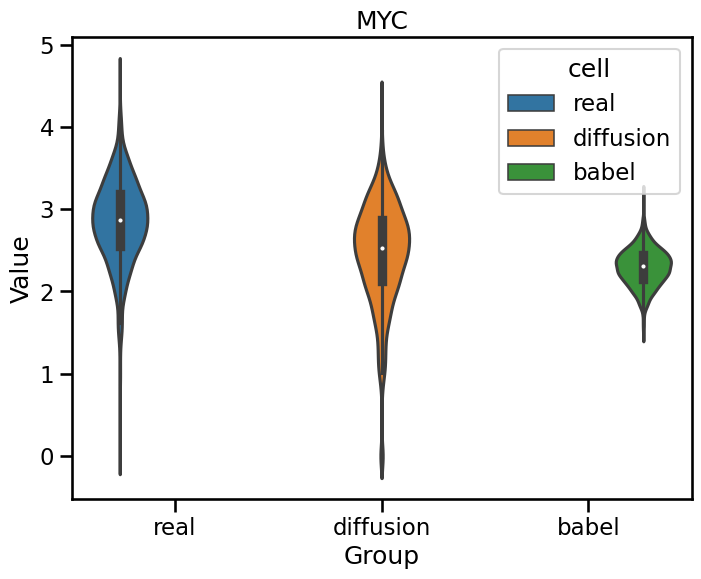

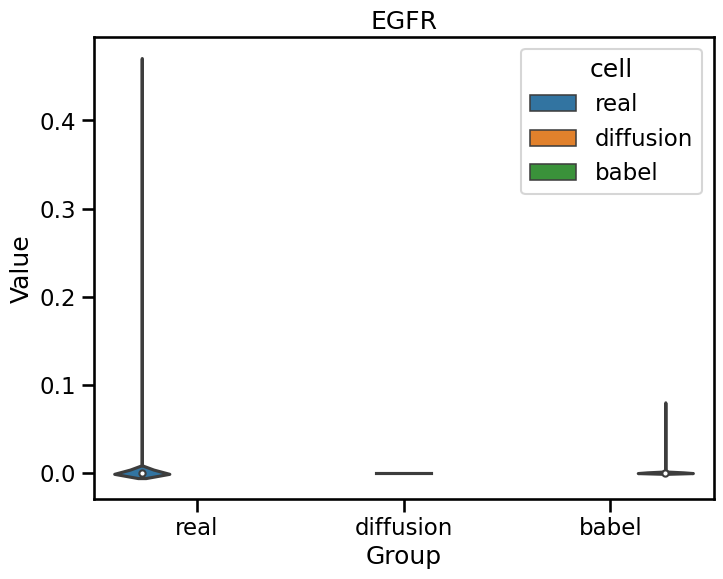

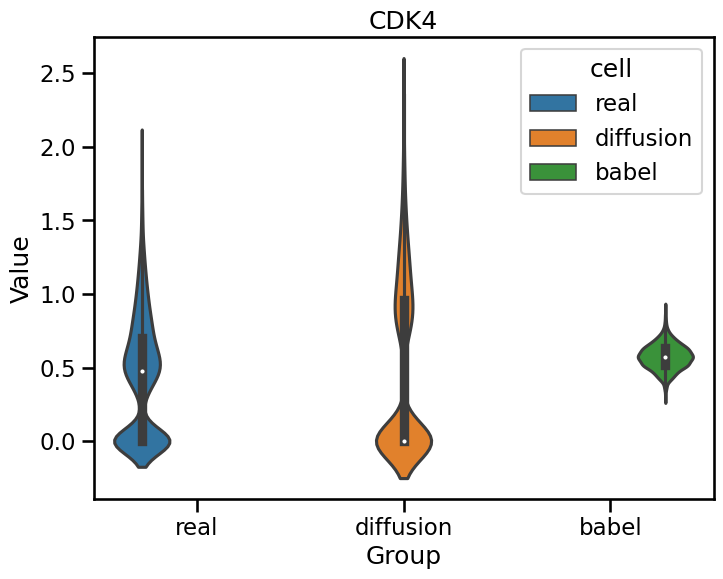

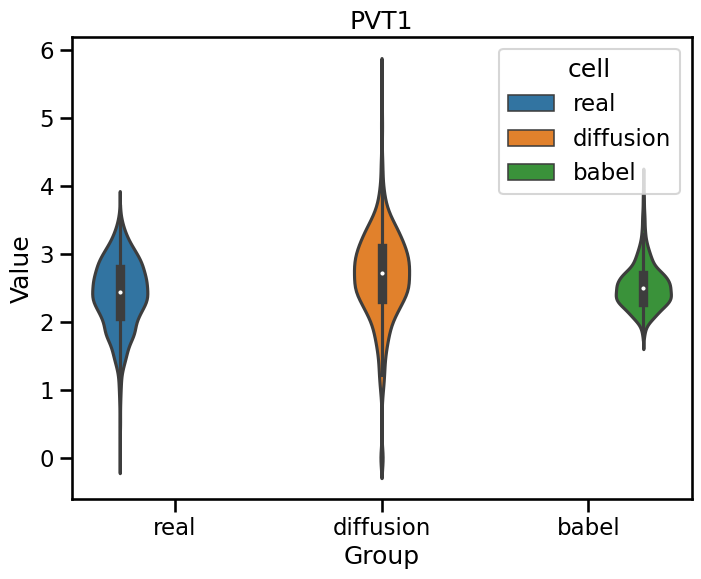

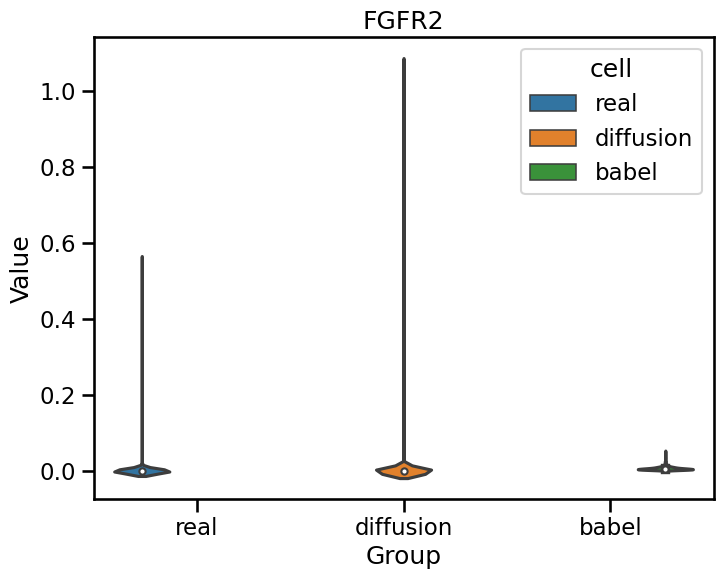

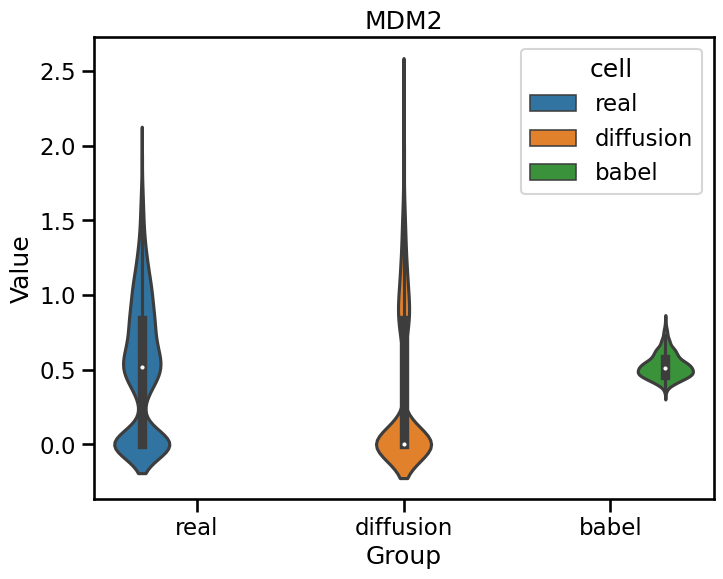

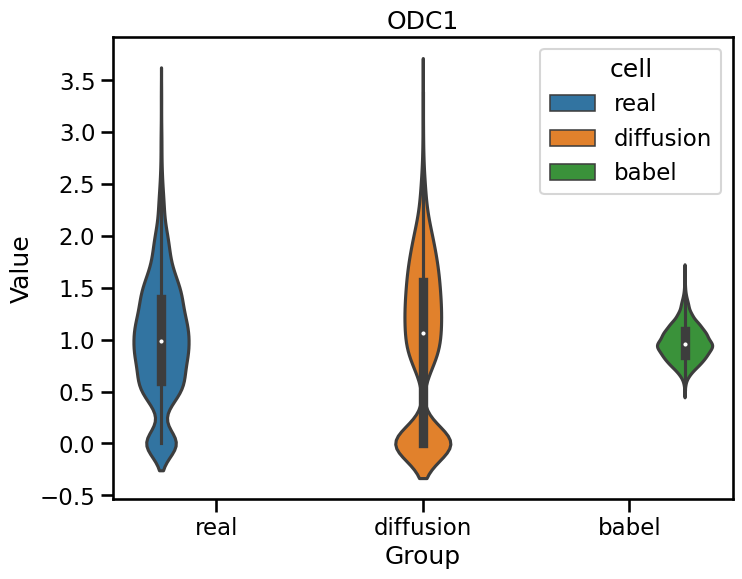

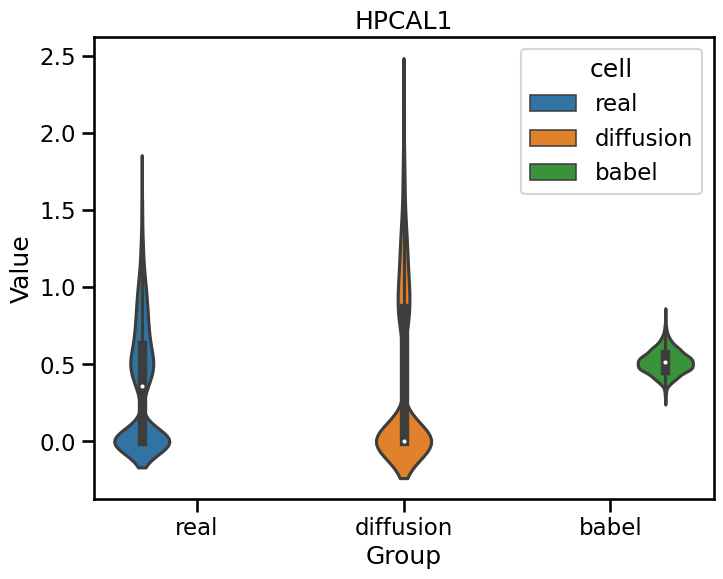

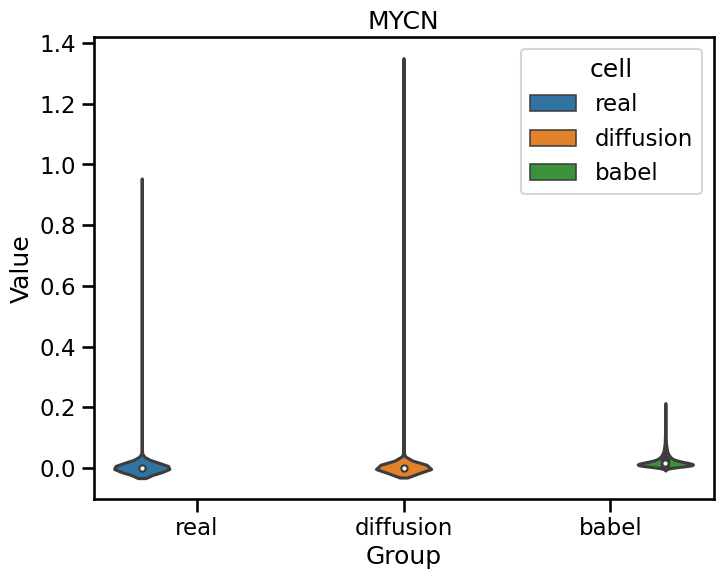

In [ ]:
marker_gene = ['MYC','EGFR','CDK4','PVT1','FGFR2','MDM2','ODC1','HPCAL1','MYCN']
for marker in marker_gene:
    real_marker = real_cell[:,np.where(mdata['rna'].var_names==marker)[0]].squeeze(-1)
    gen_marker = reconstruct[:,np.where(mdata['rna'].var_names==marker)[0]].squeeze(-1)
    gen_marker_babel = babel[:,np.where(mdata['rna'].var_names==marker)[0]].squeeze(-1)
    real_marker = np.log1p(real_marker)
    gen_marker = np.log1p(gen_marker)
    gen_marker_babel = np.log1p(gen_marker_babel)
    group_1 = real_marker
    group_2 = gen_marker
    group_3 = gen_marker_babel

    # 创建DataFrame
    data = pd.DataFrame({
        'Value': np.concatenate([group_1, group_2, group_3]),
        'Group': ['real'] * len(group_1) + ['diffusion'] * len(group_2) + ['babel'] * len(group_3),
        'cell': ['real'] * len(group_1) + ['diffusion'] * len(group_2) + ['babel'] * len(group_3)
    })

    # 绘制拆分小提琴图
    plt.figure(figsize=(8, 6))
    sns.violinplot(x='Group', y='Value', hue='cell', data=data)

    # 显示图
    plt.title(marker)
    # plt.savefig(f'/stor/lep/workspace/multi_diffusion/MM-Diffusion/evaluate_script/figures/translation/violin&distribution/violin_{marker}.pdf', dpi=300, bbox_inches='tight')
    # plt.show()

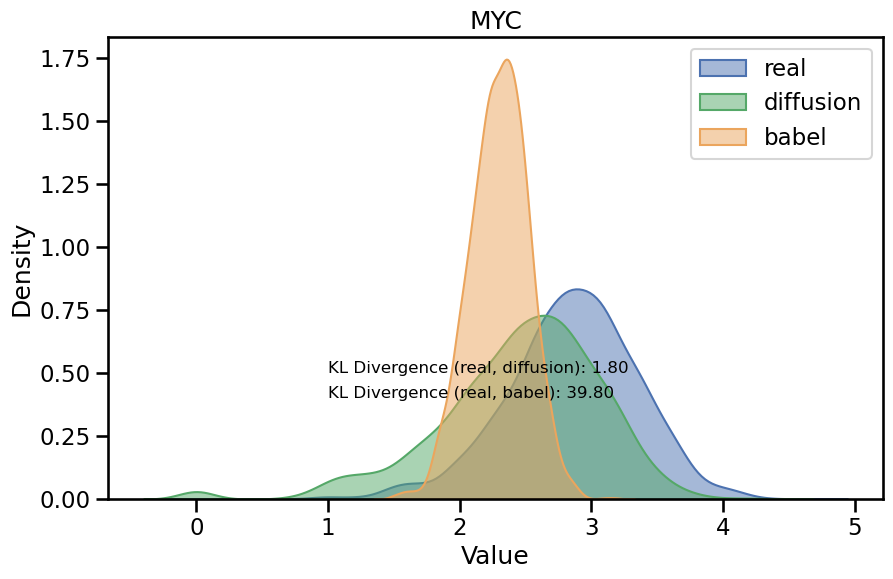

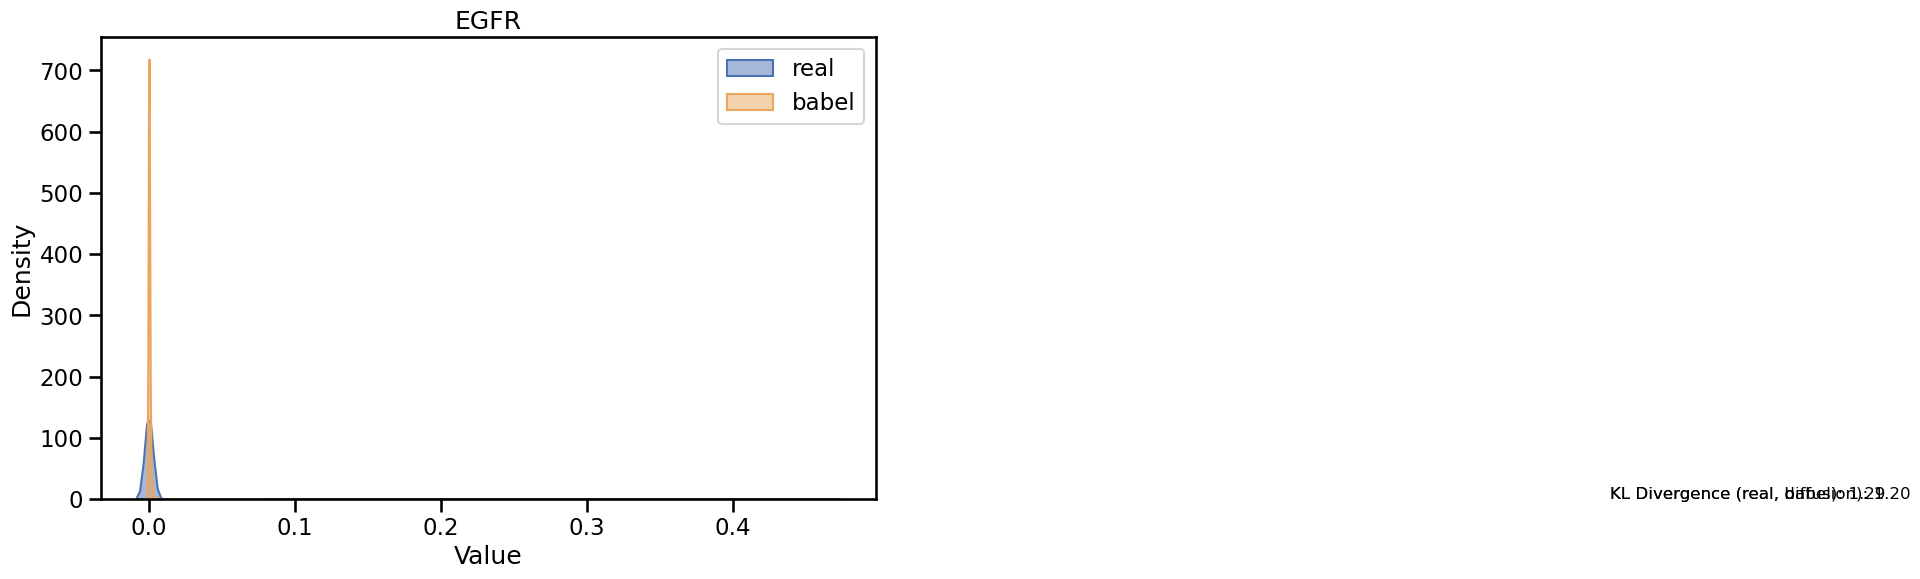

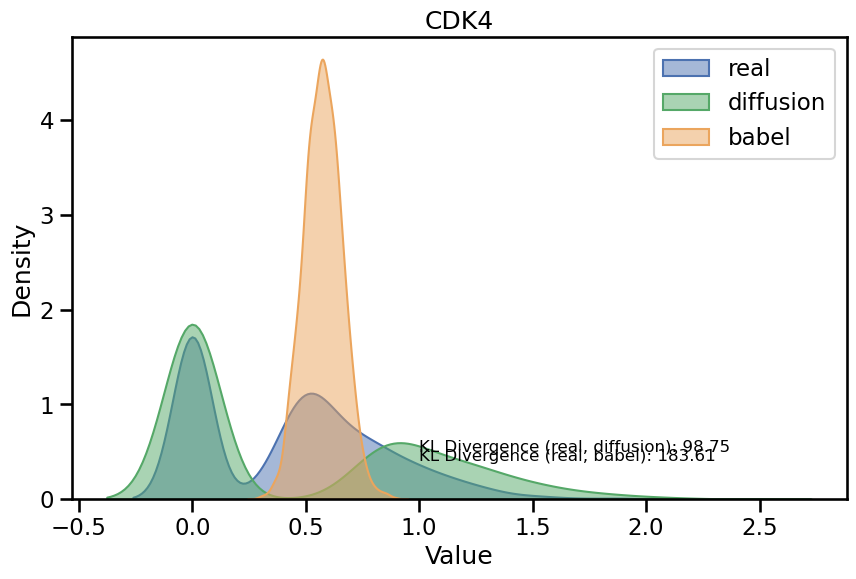

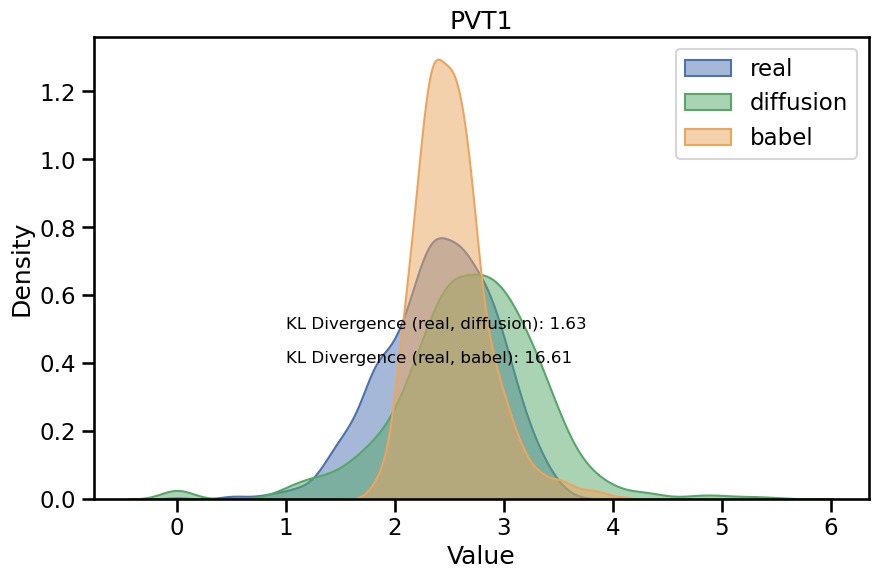

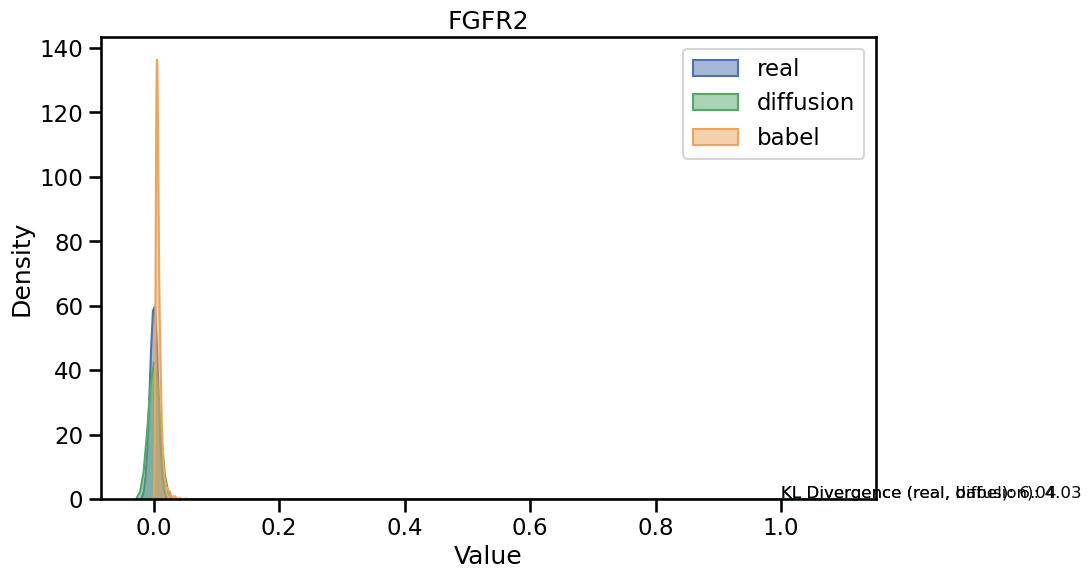

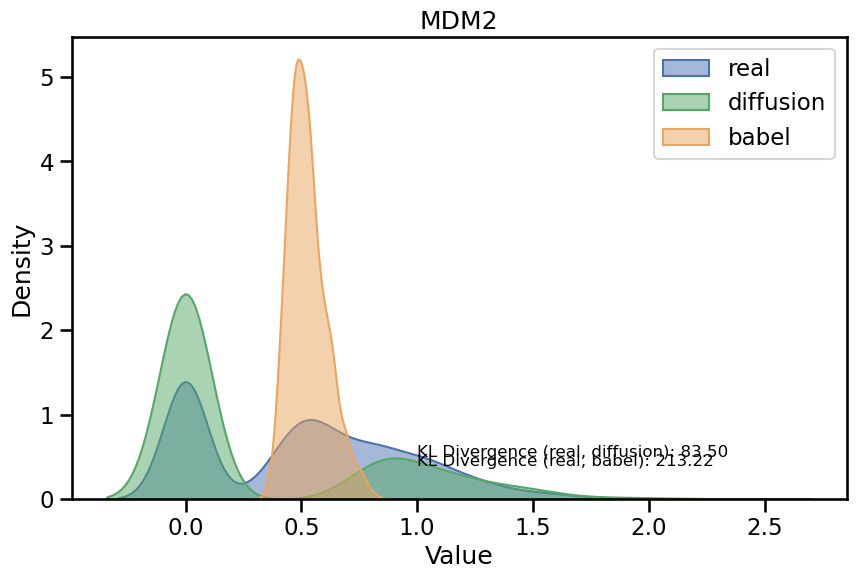

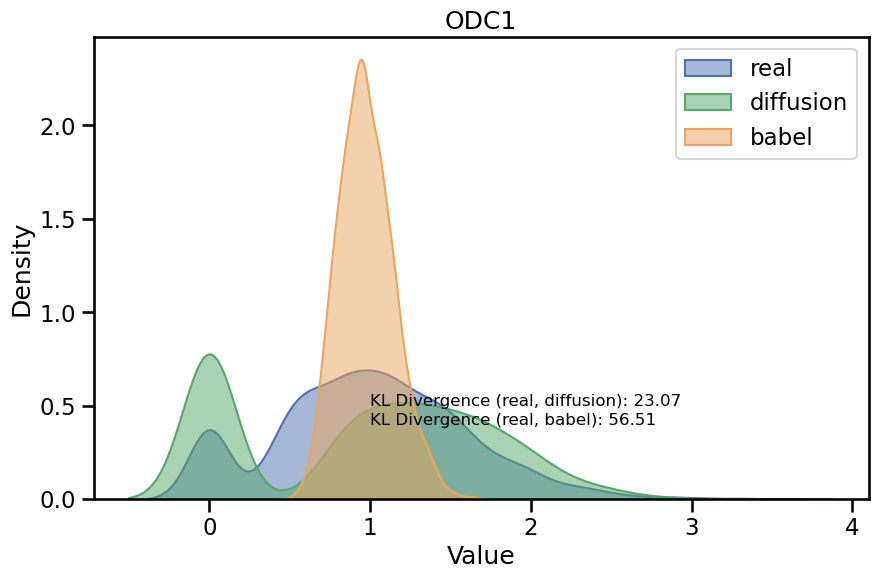

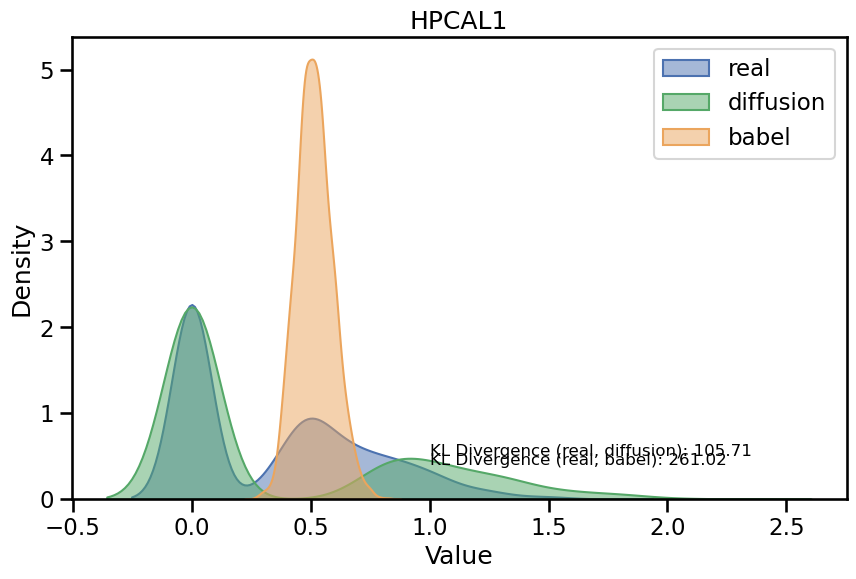

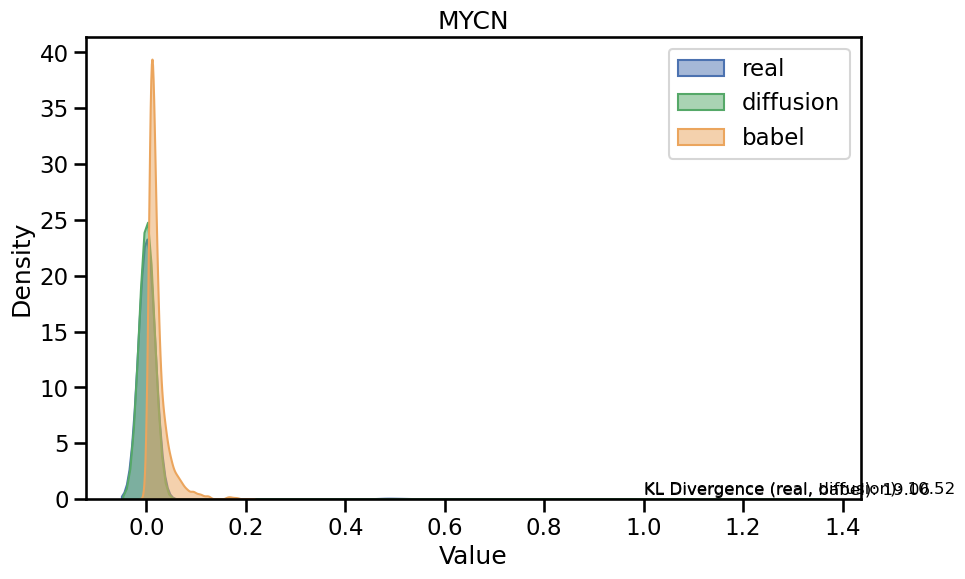

In [253]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import kl_div

marker_gene = ['MYC','EGFR','CDK4','PVT1','FGFR2','MDM2','ODC1','HPCAL1','MYCN']
for marker in marker_gene:
    real_marker = real_cell[:,np.where(mdata['rna'].var_names==marker)[0]].squeeze(-1)
    gen_marker = reconstruct[:,np.where(mdata['rna'].var_names==marker)[0]].squeeze(-1)
    gen_marker_babel = babel[:,np.where(mdata['rna'].var_names==marker)[0]].squeeze(-1)
    real_marker = np.log1p(real_marker)
    gen_marker = np.log1p(gen_marker)
    gen_marker_babel = np.log1p(gen_marker_babel)

    data1 = real_marker
    data2 = gen_marker
    data3 = gen_marker_babel

    # 创建画布和子图
    plt.figure(figsize=(10, 6))

    # 绘制第一组数据的分布
    sns.kdeplot(data1, fill=True, color='#4C72B0', alpha=0.5, label='real')

    # 绘制第二组数据的分布
    sns.kdeplot(data2, fill=True, color='#55A868', alpha=0.5, label='diffusion')

    # 绘制第三组数据的分布
    sns.kdeplot(data3, fill=True, color='#EBA55D', alpha=0.5, label='babel')

    # 添加 legend 和标题
    plt.legend()
    plt.title(marker)
    plt.xlabel('Value')
    plt.ylabel('Density')

    # 计算 KL 散度并显示
    # 需要归一化数据以适应 KL 散度的计算
    hist1, bin_edges1 = np.histogram(data1, bins=30, density=True)
    hist2, _ = np.histogram(data2, bins=bin_edges1, density=True)
    hist3, _ = np.histogram(data3, bins=bin_edges1, density=True)

    # 避免 NaN 产生
    hist1 = np.where(hist1 == 0, 1e-10, hist1)
    hist2 = np.where(hist2 == 0, 1e-10, hist2)
    hist3 = np.where(hist3 == 0, 1e-10, hist3)

    kl_div1_2 = kl_div(hist1, hist2).sum()
    kl_div1_3 = kl_div(hist1, hist3).sum()
    kl_div2_3 = kl_div(hist2, hist3).sum()

    plt.text(1, 0.5, f'KL Divergence (real, diffusion): {kl_div1_2:.2f}', fontsize=12, color='black')
    plt.text(1, 0.4, f'KL Divergence (real, babel): {kl_div1_3:.2f}', fontsize=12, color='black')

    # 显示图形
    # plt.show()
    plt.savefig(f'/stor/lep/workspace/multi_diffusion/MM-Diffusion/evaluate_script/figures/translation/violin&distribution/distribution_{marker}.pdf', dpi=300, bbox_inches='tight')


# gene perturbation

set cell type information

In [136]:
test = sc.read_10x_h5('/stor/lep/data/BABEL/HSR_rep7.h5')
test

AnnData object with n_obs × n_vars = 6427 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

In [140]:
(test.var_names.values=='KRAS').sum()

1

In [137]:
np.in1d(test.obs_names.values,mdata['rna'].obs_names).sum()

971

In [126]:
mdata = mu.read_h5mu('/stor/lep/data/BABEL/test.h5mu')
mdata['rna'].obs_names = ['-'.join(name.split('-')[:2]) for name in mdata['rna'].obs_names]

In [115]:
pbmc_mdata = mu.read_h5mu('/stor/lep/data/pbmc10k_multiome/cfgen/pbmc10k_multiome_all.h5mu')
mdata['rna'].obs_names = ['-'.join(name.split('-')[:2]) for name in mdata['rna'].obs_names]

from tqdm import tqdm
mdata['rna'].obs_names_make_unique()
mdata['rna'].obs['cell_type'] = 'unknow'
for obs_name in tqdm(mdata['rna'].obs_names.values):
    if obs_name in pbmc_mdata['rna'].obs_names.values:
        mdata['rna'].obs.loc[obs_name, 'cell_type'] = pbmc_mdata['rna'][obs_name].obs['cell_type'].values[0]

100%|██████████| 2004/2004 [00:00<00:00, 6208.52it/s]


In [117]:
np.unique(mdata['rna'].obs['cell_type'].values,return_counts=True)

(array(['CD56 (dim) NK cells', 'classical monocytes',
        'effector CD8 T cells', 'intermediate monocytes', 'memory B cells',
        'memory CD4 T cells', 'naive B cells', 'naive CD4 T cells',
        'naive CD8 T cells', 'non-classical monocytes', 'unknow'],
       dtype=object),
 array([   1,    5,    1,    4,    5,    5,    2,    2,    7,    2, 1970]))

In [ ]:
# mdata.write_h5mu('/stor/lep/data/BABEL/train_celltype.h5mu')

perturb ground truth

In [509]:
dataset_path = '/stor/lep/diffusion/multiome/openproblem_filtered4perturb.h5mu'
mdata = mu.read_h5mu(dataset_path)
mdata['atac'].var_names = [name.replace(':','-') for name in mdata['atac'].var_names]

In [510]:
def parse_region(region):
    """解析染色体区域字符串成 (染色体, 起始位置, 结束位置) 的元组"""
    chr_id, start, end = region.split('-')
    return chr_id, int(start), int(end)

def calculate_overlap(region1, region2):
    """计算两个染色体区域的重叠长度"""
    chr1, start1, end1 = region1
    chr2, start2, end2 = region2
    if chr1 == chr2:  # 只有染色体相同才计算重叠
        overlap = max(0, min(end1, end2) - max(start1, start2))
        return overlap
    return 0

In [511]:
pert = sc.read_h5ad('/stor/lep/workspace/multi_diffusion/filtered.h5ad')

/home/lep/miniconda3/envs/mm-diffusion/lib/python3.8/site-packages/anndata/_io/specs/methods.py:584: OldFormatWarning: Element '/obs/__categories/gene' was written without encoding metadata.
  categories = read_elem(categories_dset)
/home/lep/miniconda3/envs/mm-diffusion/lib/python3.8/site-packages/anndata/_io/specs/methods.py:587: OldFormatWarning: Element '/obs/gene' was written without encoding metadata.
  read_elem(dataset), categories, ordered=ordered
/home/lep/miniconda3/envs/mm-diffusion/lib/python3.8/site-packages/anndata/_io/specs/methods.py:590: OldFormatWarning: Element '/obs/_index' was written without encoding metadata.
  return read_elem(dataset)
/home/lep/miniconda3/envs/mm-diffusion/lib/python3.8/site-packages/anndata/_io/specs/methods.py:590: OldFormatWarning: Element '/var/_index' was written without encoding metadata.
  return read_elem(dataset)


In [179]:
results_all = []

for region1 in mdata['atac'].var_names:
    chr1, start1, end1 = parse_region(region1)
    max_overlap = 0
    best_match = None
    for region2 in pert.var_names.values:
        chr2, start2, end2 = parse_region(region2)
        if chr2 != chr1:
            continue
        overlap = calculate_overlap((chr1, start1, end1), (chr2, start2, end2))
        if overlap > max_overlap:
            max_overlap = overlap
            best_match = region2
    if best_match is not None:
        results_all.append(best_match)

In [512]:
filtered_genes = pert.var.index.isin(np.unique(results_all))
pert = pert[:,filtered_genes]
sc.pp.normalize_total(pert, 1e4)
sc.pp.log1p(pert)
pert

AnnData object with n_obs × n_vars = 5816 × 5962
    obs: 'gene'
    uns: 'log1p'

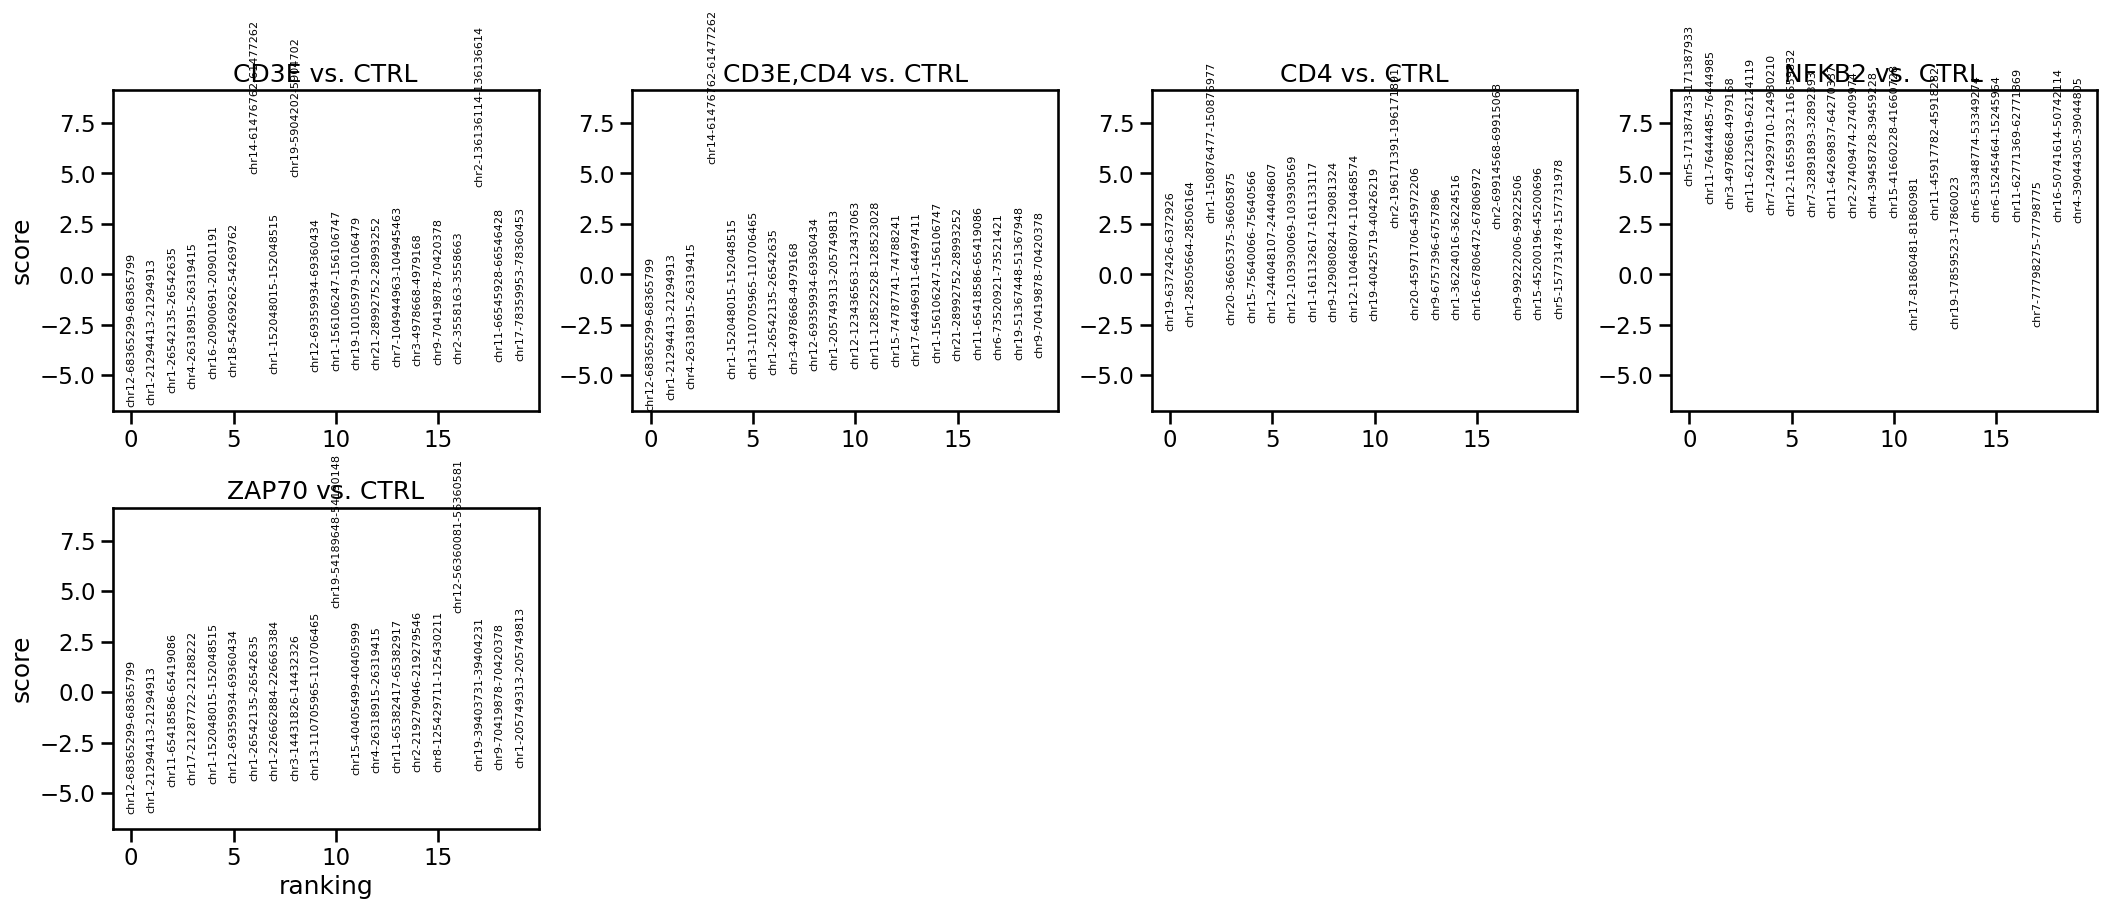

In [513]:
sc.tl.rank_genes_groups(pert,'gene', method='wilcoxon',reference='CTRL',rankby_abs=True) 
sc.pl.rank_genes_groups(pert)

In [553]:
rec_arr = pert.uns['rank_genes_groups']['names']
target_gene = 'CD3E,CD4'  #'CD3E' 'NFKB2' 'ZAP70' 'CD3E,CD4'
de_gene = np.array([rec_arr[target_gene],])[0,:300]
atac_pert = (pert[pert.obs['gene']==target_gene,de_gene].X.toarray()).astype(np.float32)
atac_ctrl = (pert[pert.obs['gene']=='CTRL',de_gene].X.toarray()).astype(np.float32)
direction_real = atac_pert.mean(0) - atac_ctrl.mean(0)
direction_real.shape

(300,)

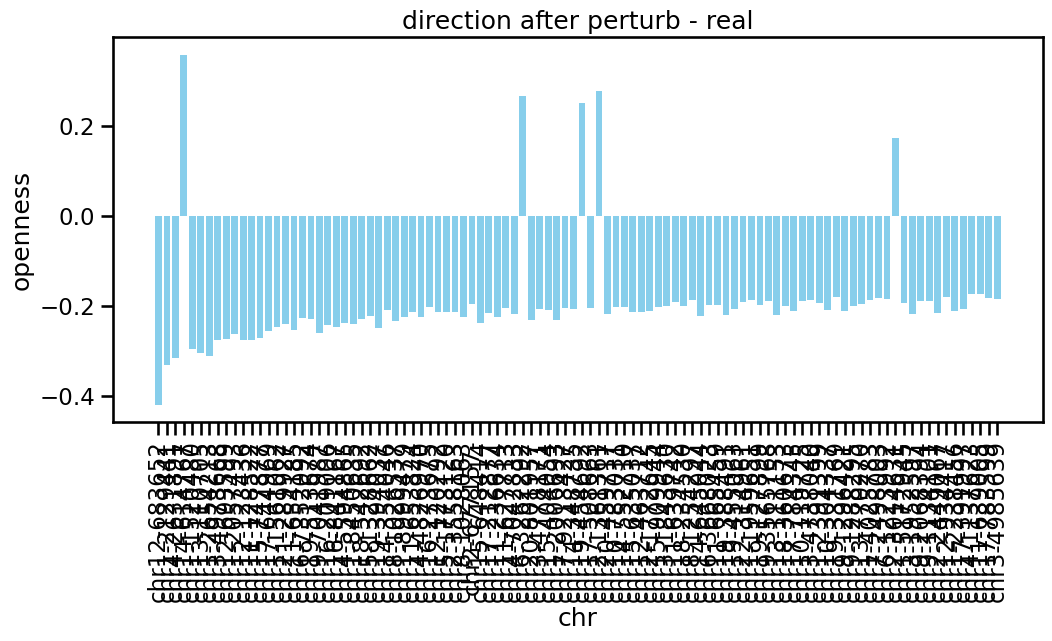

In [564]:
x_tick = [chr[:12] for chr in de_gene[:100]]
plt.figure(figsize=(12,5))
plt.bar(x_tick, direction_real[:100], color='skyblue')
plt.xticks(rotation=90)
plt.title('direction after perturb - real')
plt.xlabel('chr')
plt.ylabel('openness')
plt.show()

In [150]:
from scipy import stats

for i, item in enumerate(de_gene):
    print('\n',item)
    # 样本 A 和样本 B
    sample_A = atac_pert[:,i]
    sample_B = atac_ctrl[:,i]

    # 步骤 1：检验两个样本均值是否有显著差异
    t_statistic, p_value = stats.ttest_ind(sample_A, sample_B)

    print("步骤 1: 两独立样本 t 检验")
    print("t 统计量:", t_statistic)
    print("p 值:", p_value)

    # 检查是否存在显著差异
    alpha = 0.05
    if p_value < alpha:
        print("拒绝零假设：两个样本的均值存在显著差异。")
    else:
        print("未拒绝零假设：两个样本的均值不存在显著差异。")

    # 如果两个样本存在显著差异，我们继续执行步骤 2
    if p_value < alpha:
        # 步骤 2：比较一个样本是否显著高于或低于另一个样本
        # 这里我们以样本 A 是否显著高于样本 B 为例
        t_statistic_one_tailed, p_value_one_tailed = stats.ttest_ind(sample_A, sample_B, alternative='greater')

        print("步骤 2: 单尾检验(pert > ctrl)")
        print("t 统计量:", t_statistic_one_tailed)
        print("p 值（单尾）:", p_value_one_tailed)

        # 检查样本 A 是否显著大于样本 B
        if p_value_one_tailed < alpha:
            print("拒绝零假设：pert 的均值显著高于 ctrl 的均值。")
        else:
            print("未拒绝零假设：pert 的均值不显著高于 ctrl 的均值。")


 chr13-48653384-48653884
步骤 1: 两独立样本 t 检验
t 统计量: 11.152458101024614
p 值: 6.083577733853871e-28
拒绝零假设：两个样本的均值存在显著差异。
步骤 2: 单尾检验(pert > ctrl)
t 统计量: 11.152458101024614
p 值（单尾）: 3.0417888669269354e-28
拒绝零假设：pert 的均值显著高于 ctrl 的均值。

 chr8-20493092-20493592
步骤 1: 两独立样本 t 检验
t 统计量: 10.74184379169862
p 值: 4.215739352672885e-26
拒绝零假设：两个样本的均值存在显著差异。
步骤 2: 单尾检验(pert > ctrl)
t 统计量: 10.74184379169862
p 值（单尾）: 2.1078696763364424e-26
拒绝零假设：pert 的均值显著高于 ctrl 的均值。

 chr19-5904202-5904702
步骤 1: 两独立样本 t 检验
t 统计量: 7.71074439162437
p 值: 2.0953696158425407e-14
拒绝零假设：两个样本的均值存在显著差异。
步骤 2: 单尾检验(pert > ctrl)
t 统计量: 7.71074439162437
p 值（单尾）: 1.0476848079212704e-14
拒绝零假设：pert 的均值显著高于 ctrl 的均值。

 chr20-5714526-5715026
步骤 1: 两独立样本 t 检验
t 统计量: 9.245074680610744
p 值: 6.687844036538071e-20
拒绝零假设：两个样本的均值存在显著差异。
步骤 2: 单尾检验(pert > ctrl)
t 统计量: 9.245074680610744
p 值（单尾）: 3.3439220182690354e-20
拒绝零假设：pert 的均值显著高于 ctrl 的均值。

 chr1-224623735-224624235
步骤 1: 两独立样本 t 检验
t 统计量: 10.034807716383682
p 值: 4.514995891867171e-23
拒绝零

In [554]:
# rna_seq = np.load('../outputs/samples_trans/babel_nocondi_layernorm_pert/80w_atac2rna_CTRL_x25_grad3/RNA_0.npz')['data']#[:3064]
# atac_seq = np.load(f'../outputs/samples_trans/babel_nocondi_layernorm_pert/80w_rna2atac_{target_gene}_x25_grad3/ATAC_0.npz')['data']#[:3064]
# type_index = np.load(f'../outputs/samples_trans/babel_nocondi_layernorm_pert/80w_atac2rna_CTRL_typeindex_grad3/RNA_0.npz')['label']
# type_index = np.concatenate([type_index for i in range(25)])
rna_seq = np.load(f'../outputs/samples_trans/open_uncondi_layernorm_pert/80w_atac2rna_CTRL_{target_gene}_top5_x5/RNA_0.npz')['data']
atac_seq = np.load(f'../outputs/samples_trans/open_uncondi_layernorm_pert/80w_rna2atac_{target_gene}_top5_x5/ATAC_0.npz')['data']
type_index = np.load(f'../outputs/samples_trans/open_uncondi_layernorm_pert/80w_atac2rna_CTRL_{target_gene}_top5_x5/RNA_0.npz')['label']


# train_mdata = mu.read_h5mu('/stor/lep/data/BABEL/train_celltype.h5mu')
# selected_cell_types = ['naive CD4 T cells', 'memory CD4 T cells']
# type_index = type_index[train_mdata['rna'].obs['cell_type'].isin(selected_cell_types)]
times = 5
rna_seq = rna_seq.reshape(times,-1,rna_seq.shape[-1])[0]#.mean(0)
# atac_seq = atac_seq.reshape(times,-1,atac_seq.shape[-1])[0]#.mean(0)
type_index = type_index[:rna_seq.shape[0]]

npzfile = np.load('/'.join(ae_path.split('/')[:-2])+'/norm_factor.npz')
rna_std = npzfile['rna_std']
atac_std = npzfile['atac_std']
z = {'rna':torch.tensor(rna_seq*rna_std).squeeze(1),'atac':torch.tensor(atac_seq*atac_std).squeeze(1)}     # open  layernorm

size_factor = get_size_factor(torch.tensor(type_index,dtype=torch.int))  # cell type average
# size_factor = {'rna':torch.tensor(mdata_rna.X.toarray().sum(1)).unsqueeze(-1)} # ground truth

mu_hat = encoder_model.decode(z, size_factor)

# mu_hat['rna'] = mu_hat['rna'].reshape(times,-1,mu_hat['rna'].shape[-1]).mean(0)
mu_hat['atac'] = mu_hat['atac'].reshape(times,-1,mu_hat['atac'].shape[-1]).mean(0)

sample = {}  # containing final samples 
for mod in mu_hat:
    if mod=="rna":  
        # if not self.covariate_specific_theta:
        distr = NegativeBinomial(mu=mu_hat[mod], theta=torch.exp(encoder_model.theta))
    else:  # if mod is atac
        if not encoder_model.is_binarized:
            distr = Poisson(rate=mu_hat[mod])
        else:
            distr = Bernoulli(probs=mu_hat[mod])
    sample[mod] = distr.sample() 

reconstruct_pert = mu_hat['rna'].detach().numpy()
reconstruct2_pert = mu_hat['atac'].detach().numpy()
# reconstruct_pert =  sample['rna'].detach().numpy()#[::5]#.reshape(times,-1,sample['rna'].shape[-1]).mean(0) # sample['rna'].detach().numpy()
# reconstruct2_pert = sample['atac'].detach().numpy()#[::5]#.reshape(times,-1,sample['atac'].shape[-1]).mean(0) # sample['atac'].detach().numpy()
# reconstruct2 = (reconstruct2.sum(0)>3).astype(np.float32)

reconstruct_pert.shape, reconstruct2_pert.shape

((564, 2503), (564, 6016))

In [555]:
rna_seq = np.load(f'../outputs/samples_trans/open_uncondi_layernorm_pert/80w_atac2rna_CTRL_{target_gene}_top5_x5/RNA_0.npz')['data']#[:3064]
atac_seq = np.load(f'../outputs/samples_trans/open_uncondi_layernorm_pert/80w_rna2atac_CTRL_{target_gene}_top5_x5/ATAC_0.npz')['data']#[:3064]
# type_index = np.load(f'../outputs/samples_trans/babel_nocondi_layernorm_pert/80w_atac2rna_CTRL_x25_grad3/RNA_0.npz')['label']
type_index = np.load(f'../outputs/samples_trans/open_uncondi_layernorm_pert/80w_atac2rna_CTRL_{target_gene}_top5_x5/RNA_0.npz')['label']
# type_index = np.concatenate([type_index for i in range(25)])

# train_mdata = mu.read_h5mu('/stor/lep/data/BABEL/train_celltype.h5mu')
# selected_cell_types = ['naive CD4 T cells', 'memory CD4 T cells']
# type_index = type_index[train_mdata['rna'].obs['cell_type'].isin(selected_cell_types)]
times = 5
rna_seq = rna_seq.reshape(times,-1,rna_seq.shape[-1])[0]#.mean(0)
# atac_seq = atac_seq.reshape(times,-1,atac_seq.shape[-1])[0]#.mean(0)
type_index = type_index[:rna_seq.shape[0]]

npzfile = np.load('/'.join(ae_path.split('/')[:-2])+'/norm_factor.npz')
rna_std = npzfile['rna_std']
atac_std = npzfile['atac_std']
z = {'rna':torch.tensor(rna_seq*rna_std).squeeze(1),'atac':torch.tensor(atac_seq*atac_std).squeeze(1)}     # open  layernorm

size_factor = get_size_factor(torch.tensor(type_index,dtype=torch.int))  # cell type average
# size_factor = {'rna':torch.tensor(mdata_rna.X.toarray().sum(1)).unsqueeze(-1)} # ground truth

mu_hat = encoder_model.decode(z, size_factor)

# mu_hat['rna'] = mu_hat['rna'].reshape(times,-1,mu_hat['rna'].shape[-1]).mean(0)
mu_hat['atac'] = mu_hat['atac'].reshape(times,-1,mu_hat['atac'].shape[-1]).mean(0)

sample = {}  # containing final samples 
for mod in mu_hat:
    if mod=="rna":  
        # if not self.covariate_specific_theta:
        distr = NegativeBinomial(mu=mu_hat[mod], theta=torch.exp(encoder_model.theta))
    else:  # if mod is atac
        if not encoder_model.is_binarized:
            distr = Poisson(rate=mu_hat[mod])
        else:
            distr = Bernoulli(probs=mu_hat[mod])
    sample[mod] = distr.sample() 

reconstruct_ctrl = mu_hat['rna'].detach().numpy()
reconstruct2_ctrl = mu_hat['atac'].detach().numpy()
# reconstruct_ctrl =  sample['rna'].detach().numpy()#[::5]#.reshape(times,-1,sample['rna'].shape[-1]).mean(0) # sample['rna'].detach().numpy()
# reconstruct2_ctrl = sample['atac'].detach().numpy()#[::5]#.reshape(times,-1,sample['atac'].shape[-1]).mean(0) # sample['atac'].detach().numpy()
# reconstruct2 = (reconstruct2.sum(0)>3).astype(np.float32)

reconstruct_ctrl.shape, reconstruct2_ctrl.shape

((564, 2503), (564, 6016))

In [556]:
reconstruct2_pert=norm_total(reconstruct2_pert, 1e4)
# reconstruct2_pert=np.log1p(reconstruct2_pert)
reconstruct2_ctrl=norm_total(reconstruct2_ctrl, 1e4)
# reconstruct2_ctrl=np.log1p(reconstruct2_ctrl)

In [557]:
# 为每个 array1 中的染色质片段找到重叠最大的 array2 中片段
results = []

for region1 in de_gene:
    chr1, start1, end1 = parse_region(region1)
    max_overlap = 0
    best_match = None
    for region2 in mdata['atac'].var_names:
        chr2, start2, end2 = parse_region(region2)
        if chr2 != chr1:
            continue
        overlap = calculate_overlap((chr1, start1, end1), (chr2, start2, end2))
        if overlap > max_overlap:
            max_overlap = overlap
            best_match = region2
    results.append((region1, best_match, max_overlap))

# 打印结果
for item in results:
    print(f"Array1: {item[0]} | Best Match: {item[1]} | Overlap: {item[2]}")

Array1: chr12-68365299-68365799 | Best Match: chr12-68364912-68365816 | Overlap: 500
Array1: chr1-21294413-21294913 | Best Match: chr1-21294217-21295110 | Overlap: 500
Array1: chr4-26318915-26319415 | Best Match: chr4-26319060-26319944 | Overlap: 355
Array1: chr14-61476762-61477262 | Best Match: chr14-61476538-61477429 | Overlap: 500
Array1: chr1-152048015-152048515 | Best Match: chr1-152047784-152048690 | Overlap: 500
Array1: chr13-110705965-110706465 | Best Match: chr13-110705768-110706683 | Overlap: 500
Array1: chr1-26542135-26542635 | Best Match: chr1-26541746-26542651 | Overlap: 500
Array1: chr3-4978668-4979168 | Best Match: chr3-4978740-4979475 | Overlap: 428
Array1: chr12-69359934-69360434 | Best Match: chr12-69359588-69360414 | Overlap: 480
Array1: chr1-205749313-205749813 | Best Match: chr1-205749221-205749916 | Overlap: 500
Array1: chr12-123436563-123437063 | Best Match: chr12-123436254-123437143 | Overlap: 500
Array1: chr11-128522528-128523028 | Best Match: chr11-128521993-1

In [558]:
pred_pert = reconstruct2_pert#.reshape(25,-1,reconstruct2_pert.shape[-1]).mean(1)#[:,[np.where(mdata['atac'].var_names == x)[0][0] for x in de_gene]]
pred_ctrl = reconstruct2_ctrl#.reshape(25,-1,reconstruct2_pert.shape[-1]).mean(1)#[:,[np.where(mdata['atac'].var_names == x)[0][0] for x in de_gene]]
direction_pred_pred = pred_pert.mean(0) - pred_ctrl.mean(0)
direction = []
for item in results:
    if item[1] is not None:
        direction.append(direction_pred_pred[np.where(mdata['atac'].var_names == item[1])[0][0]])
    else:
        direction.append(0)

In [ ]:
delta = reconstruct2_pert.reshape(times,-1,mu_hat['atac'].shape[-1]).mean(1)-reconstruct2_ctrl.reshape(times,-1,mu_hat['atac'].shape[-1]).mean(1)
direction = []
for item in results:
    direction.append(delta[:,np.where(mdata['atac'].var_names == item[1])[0][0]])
for dir in direction:
    # print(dir.mean(),dir.var())
    print(dir)

[0.0017947  0.00151932 0.0014652  0.00157762 0.00145316]
[-0.00287056 -0.00287569 -0.00287199 -0.00295687 -0.00238383]
[0.00195044 0.0018698  0.00190449 0.00204223 0.00232607]
[-0.00182247 -0.00158834 -0.00153935 -0.0019455  -0.0016346 ]
[0.00086701 0.00085533 0.00107789 0.00087965 0.00102818]
[ 3.8450956e-04 -2.5010109e-04 -3.2961369e-05 -2.4199486e-05
  1.6987324e-04]
[-0.00026536 -0.00022423 -0.00022626 -0.00038445 -0.00033295]
[0.00143844 0.00135261 0.00175601 0.00093061 0.00119936]
[0.00131083 0.00155926 0.001369   0.00119424 0.00091147]
[-0.00109315 -0.00108695 -0.00110161 -0.00075889 -0.00085282]
[-0.00092196 -0.00137091 -0.00067914 -0.00123346 -0.00100255]
[-0.00062466 -0.00029743 -0.00076163 -0.00058234 -0.00069678]
[0.00096905 0.00099504 0.00116062 0.00071263 0.00102174]
[0.00047839 0.00060534 0.00031328 0.00041831 0.00071371]
[0.00063038 0.00088429 0.00027084 0.00091803 0.0006659 ]
[-0.00126898 -0.00131333 -0.00132918 -0.00152898 -0.00113273]
[-1.5532970e-04 -2.5212765e-04 -

In [191]:
pred_pert = reconstruct2_pert#.reshape(25,-1,reconstruct2_pert.shape[-1]).mean(1)#[:,[np.where(mdata['atac'].var_names == x)[0][0] for x in de_gene]]
pred_ctrl = reconstruct2_ctrl#.reshape(25,-1,reconstruct2_pert.shape[-1]).mean(1)#[:,[np.where(mdata['atac'].var_names == x)[0][0] for x in de_gene]]
# direction_ctrl_ctrl = pred_ctrl.mean(0) - atac_ctrl.mean(0)
# direction_pred_ctrl = pred_pert.mean(0) - atac_ctrl.mean(0)
# direction_pred_pred = pred_pert.mean(0) - pred_ctrl.mean(0)

gap = (pred_pert - pred_ctrl)
# indices = np.argmax(np.abs(gap), axis=0)
# direction_pred_pred = gap[indices, np.arange(gap.shape[1])]


# 创建一个用于存放结果的数组
top_n = 5
direction_pred_pred = np.empty((top_n, gap.shape[1]))
# direction_pred_pred = []
# 对每一列进行处理
for col in range(gap.shape[1]):
    # 获取当前列的绝对值排序的索引
    indices = np.argsort(np.abs(gap[:, col]))[-top_n:]  # 取出绝对值最大的前20个索引
    direction_pred_pred[:, col] = gap[indices, col]  # 提取原始值
    # if (gap[:,col]>0.00002).sum()>int(gap.shape[0]/2):
    #     indices = np.where(gap[:,col]>0)[0]
    # else:
    #     indices = np.where(gap[:,col]<0)[0]
    # direction_pred_pred.append(gap[indices,col].mean())

direction_pred_pred = direction_pred_pred.mean(0)
# direction_pred_pred = np.array(direction_pred_pred)

direction = []
for item in results:
    if item[1] is not None:
        direction.append(direction_pred_pred[np.where(mdata['atac'].var_names == item[1])[0][0]])
    else:
        direction.append(0)

direction_pred_pred.shape

(6016,)

In [546]:
real_pert = (pert[pert.obs['gene']==target_gene].X.toarray()).astype(np.float32)
real_ctrl = (pert[pert.obs['gene']=='CTRL'].X.toarray()).astype(np.float32)
direction_real2 = real_pert.mean(0) - real_ctrl.mean(0)
print((direction_real2>0).sum(),(direction_real2<0).sum())
print((direction_pred_pred>0).sum(),(direction_pred_pred<0).sum())

1190 4772
2951 3064


In [ ]:
# CD3ECD4
1190 4772
2894 3122

#ZAP70
1283 4679
2951 3064

In [561]:
from sklearn.metrics import accuracy_score

direction_random = np.random.randint(0, 2, size=300)

total_acc = []
posi_acc = []
nega_acc = []
total_acc_random = []
posi_acc_random = []
nega_acc_random = []
for num in [20,50,100,200,300]:
    accuracy = accuracy_score(np.array(direction_real[:num])>0, np.array(direction[:num])>0)
    total_acc.append(accuracy)
    print(f'top {num} total acc: ', accuracy)
    index_posi = np.where(np.array(direction_real[:num])>0)[0]
    accuracy = accuracy_score(np.array(direction_real[:num])[index_posi]>0, np.array(direction[:num])[index_posi]>0)
    posi_acc.append(accuracy)
    print('positive acc: ', accuracy)
    index_posi = np.where(np.array(direction_real[:num])<0)[0]
    accuracy = accuracy_score(np.array(direction_real[:num])[index_posi]>0, np.array(direction[:num])[index_posi]>0)
    nega_acc.append(accuracy)
    print('negative acc: ', accuracy)    

    accuracy = accuracy_score(np.array(direction_real[:num])>0, np.array(direction_random[:num])>0)
    total_acc_random.append(accuracy)
    print(f'top {num} total acc random: ', accuracy)
    index_posi = np.where(np.array(direction_real[:num])>0)[0]
    accuracy = accuracy_score(np.array(direction_real[:num])[index_posi]>0, np.array(direction_random[:num])[index_posi]>0)
    posi_acc_random.append(accuracy)
    print('positive acc random: ', accuracy)
    index_posi = np.where(np.array(direction_real[:num])<0)[0]
    accuracy = accuracy_score(np.array(direction_real[:num])[index_posi]>0, np.array(direction_random[:num])[index_posi]>0)
    nega_acc_random.append(accuracy)
    print('negative acc random: ', accuracy)   

top 20 total acc:  0.8
positive acc:  1.0
negative acc:  0.7894736842105263
top 20 total acc random:  0.6
positive acc random:  0.0
negative acc random:  0.631578947368421
top 50 total acc:  0.82
positive acc:  1.0
negative acc:  0.8125
top 50 total acc random:  0.58
positive acc random:  0.5
negative acc random:  0.5833333333333334
top 100 total acc:  0.77
positive acc:  1.0
negative acc:  0.7578947368421053
top 100 total acc random:  0.52
positive acc random:  0.4
negative acc random:  0.5263157894736842
top 200 total acc:  0.73
positive acc:  0.8181818181818182
negative acc:  0.7248677248677249
top 200 total acc random:  0.5
positive acc random:  0.6363636363636364
negative acc random:  0.49206349206349204
top 300 total acc:  0.6833333333333333
positive acc:  0.7647058823529411
negative acc:  0.6784452296819788
top 300 total acc random:  0.48333333333333334
positive acc random:  0.47058823529411764
negative acc random:  0.4840989399293286


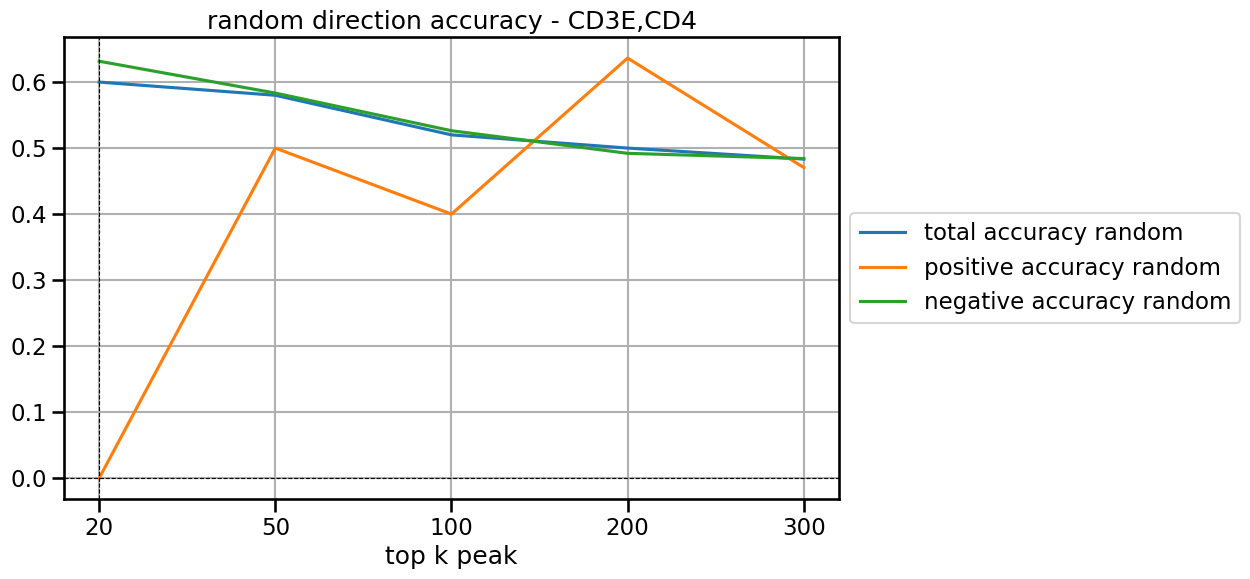

In [563]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.figure(figsize=(10, 6))  # 设置图形大小
x = np.linspace(0, 4, 5)
# plt.plot(x, total_acc, label='total accuracy') 
# plt.plot(x, posi_acc, label='positive accuracy') 
# plt.plot(x, nega_acc, label='negative accuracy') 

plt.plot(x, total_acc_random, label='total accuracy random') 
plt.plot(x, posi_acc_random, label='positive accuracy random') 
plt.plot(x, nega_acc_random, label='negative accuracy random') 


# 设置图形属性
plt.title(f'random direction accuracy - {target_gene}')        # 设置标题
plt.xlabel('top k peak')                    # 设置 x 轴标签
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(x, ['20','50','100','200','300'])
# plt.yticks([])
# plt.ylabel('Y-axis')                    # 设置 y 轴标签
# plt.ylim(0.2, 0.65)                       # 设置 y 轴范围
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # 添加水平参考线
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')  # 添加垂直参考线
plt.grid()                              # 添加网格
# plt.legend()                            # 显示图例
plt.savefig(f'/stor/lep/workspace/multi_diffusion/MM-Diffusion/evaluate_script/figures/translation/perturb/random_{target_gene}.pdf')

In [281]:
from scipy import stats

p_vals = []
for i, item in enumerate(range(pred_pert.shape[1])):#results
    # if item[1] is not None:
    if True:
        # print(item[1])
        index = i #np.where(mdata['atac'].var_names == item[1])[0][0] #top_indices[i]

        # 样本 A 和样本 B
        sample_A = pred_pert[:,index]
        sample_B = pred_ctrl[:,index]

        # 步骤 1：检验两个样本均值是否有显著差异
        t_statistic, p_value = stats.ttest_ind(sample_A, sample_B)
        p_vals.append(p_value)

        # print("步骤 1: 两独立样本 t 检验")
        # print("t 统计量:", t_statistic)
        # print("p 值:", p_value)

        # # 检查是否存在显著差异
        # alpha = 0.05
        # if p_value < alpha:
        #     print("拒绝零假设：两个样本的均值存在显著差异。")
        # else:
        #     print("未拒绝零假设：两个样本的均值不存在显著差异。")

        # # 如果两个样本存在显著差异，我们继续执行步骤 2
        # if p_value < alpha:
        #     # 步骤 2：比较一个样本是否显著高于或低于另一个样本
        #     # 这里我们以样本 A 是否显著高于样本 B 为例
        #     t_statistic_one_tailed, p_value_one_tailed = stats.ttest_ind(sample_A, sample_B, alternative='greater')

        #     print("\n步骤 2: 单尾检验(pert > ctrl)")
        #     print("t 统计量:", t_statistic_one_tailed)
        #     print("p 值（单尾）:", p_value_one_tailed)

        #     # 检查样本 A 是否显著大于样本 B
        #     if p_value_one_tailed < alpha:
        #         print("拒绝零假设：pert 的均值显著高于 ctrl 的均值。")
        #     else:
        #         print("未拒绝零假设：pert 的均值不显著高于 ctrl 的均值。")

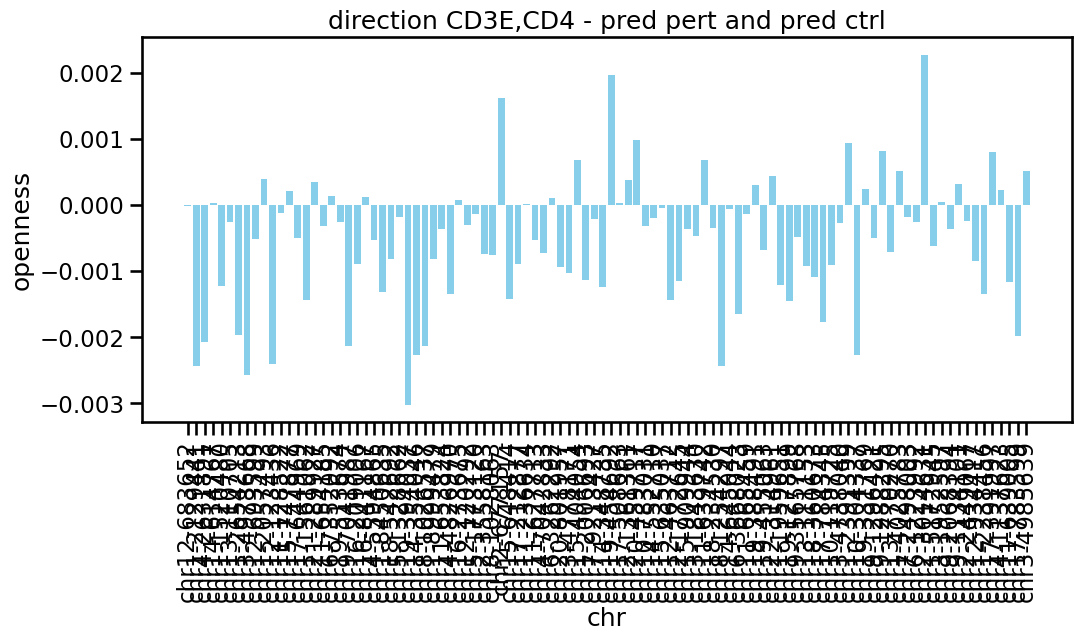

In [428]:
x_tick = [chr[:12] for chr in de_gene[:100]]
plt.figure(figsize=(12,5))
plt.bar(x_tick, direction[:100], color='skyblue')
plt.xticks(rotation=90)
plt.title(f'direction {target_gene} - pred pert and pred ctrl')
plt.xlabel('chr')
plt.ylabel('openness')
plt.show()

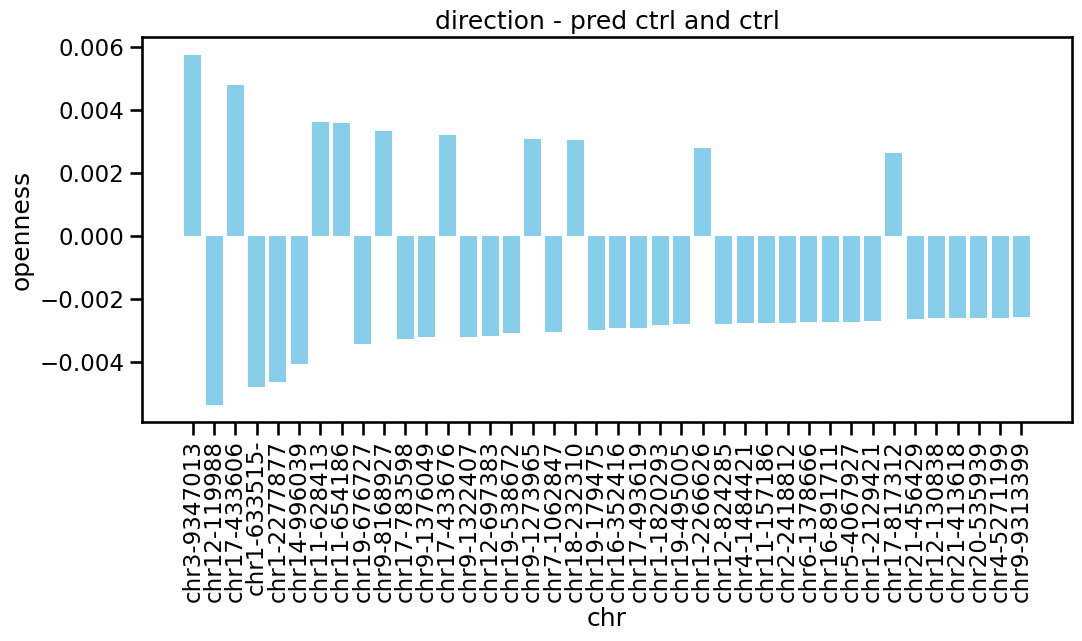

In [209]:
sorted_indices = np.argsort(abs(direction_pred_pred))
top_indices = sorted_indices[-40:][::-1]
top_elements = direction_pred_pred[top_indices]

x_tick = [chr[:12] for chr in mdata['atac'].var_names[top_indices]]
plt.figure(figsize=(12,5))
plt.bar(x_tick, top_elements, color='skyblue')
plt.xticks(rotation=90)
plt.title('direction - pred ctrl and ctrl')
plt.xlabel('chr')
plt.ylabel('openness')
plt.show()

In [ ]:
算个spearman
gene设0--max_value
只拿CD3E表达高的 top<5%
生成多次取平均 取DEpeak 算cos-similarity

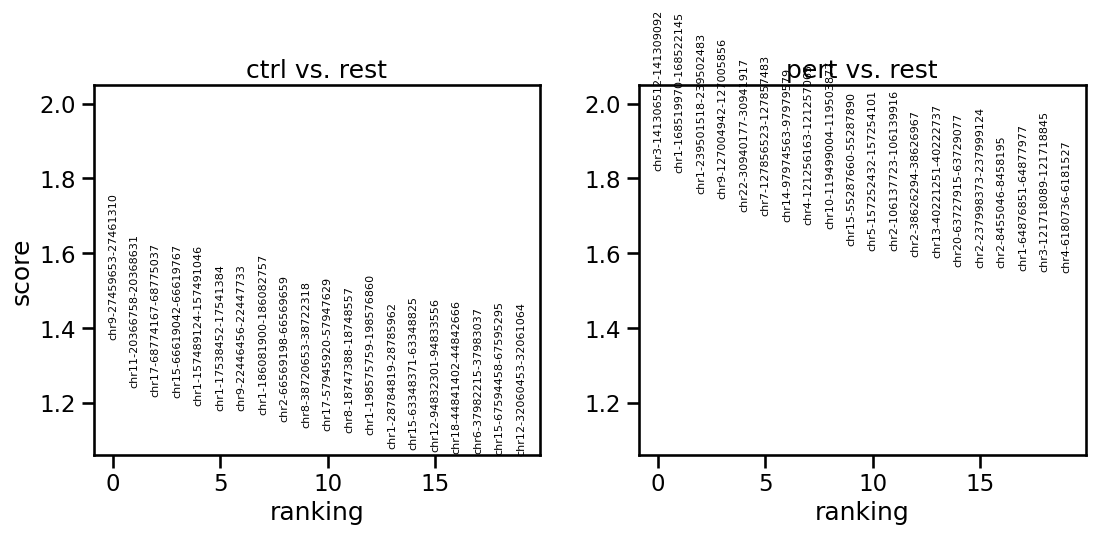

In [455]:
pert_pre = ad.AnnData(np.concatenate((reconstruct2_pert,reconstruct2_ctrl)))
pert_pre.var_names = mdata['atac'].var_names
pert_pre.obs['gene'] = ['pert']*reconstruct2_pert.shape[0] + ['ctrl']*reconstruct2_ctrl.shape[0]
sc.tl.rank_genes_groups(pert_pre,'gene', method='wilcoxon') 
sc.pl.rank_genes_groups(pert_pre)

In [173]:
rec_arr = pert_pre.uns['rank_genes_groups']['names']
# target_gene = 'CD3E'
de_gene_pre = np.array([rec_arr['pert'],])[0,:20]
atac_pert_pre = (pert_pre[pert_pre.obs['gene']=='pert',de_gene_pre].X.toarray()).astype(np.float32)
atac_ctrl_pre = (pert_pre[pert_pre.obs['gene']=='ctrl',de_gene_pre].X.toarray()).astype(np.float32)


for i, item in enumerate(de_gene_pre):
    print('\n',item)
    # 样本 A 和样本 B
    sample_A = atac_pert_pre[:,i]
    sample_B = atac_ctrl_pre[:,i]

    # 步骤 1：检验两个样本均值是否有显著差异
    t_statistic, p_value = stats.ttest_ind(sample_A, sample_B)

    print("步骤 1: 两独立样本 t 检验")
    print("t 统计量:", t_statistic)
    print("p 值:", p_value)

    # 检查是否存在显著差异
    alpha = 0.05
    if p_value < alpha:
        print("拒绝零假设：两个样本的均值存在显著差异。")
    else:
        print("未拒绝零假设：两个样本的均值不存在显著差异。")

    # 如果两个样本存在显著差异，我们继续执行步骤 2
    if p_value < alpha:
        # 步骤 2：比较一个样本是否显著高于或低于另一个样本
        # 这里我们以样本 A 是否显著高于样本 B 为例
        t_statistic_one_tailed, p_value_one_tailed = stats.ttest_ind(sample_A, sample_B, alternative='greater')

        print("步骤 2: 单尾检验(pert > ctrl)")
        print("t 统计量:", t_statistic_one_tailed)
        print("p 值（单尾）:", p_value_one_tailed)

        # 检查样本 A 是否显著大于样本 B
        if p_value_one_tailed < alpha:
            print("拒绝零假设：pert 的均值显著高于 ctrl 的均值。")
        else:
            print("未拒绝零假设：pert 的均值不显著高于 ctrl 的均值。")

NameError: name 'pert_pre' is not defined